In [2]:
import torch

device = torch.device("cuda")

In [3]:
from models.resnet import resnet8
from models.alexnet import alexnet
import numpy
from sklearn.metrics import classification_report
# import numpy


In [4]:
def one_hot(y, num_class):
    return torch.zeros((len(y), num_class)).to(y.device).scatter_(1, y.unsqueeze(1), 1)

class PairedLoss(torch.nn.Module):
    def __init__(self, T, client_dist):
        super(PairedLoss, self).__init__()
        self.T = T
        self.client_dist = client_dist
        adds = self.T * torch.pow(self.client_dist, -0.25)
        self.adds = torch.where(torch.isinf(adds),torch.zeros_like(adds),adds)

    def forward(self, inputs, targets):
        targets_onehot = one_hot(targets, inputs.shape[1])
        inputs = inputs - self.adds.to(device)

        # temp = inputs[targets_onehot == 0]
        
        up = torch.where(targets_onehot == 1,torch.exp(inputs),torch.zeros_like(inputs)).sum(dim=1)
        down = torch.exp(inputs).sum(dim=1)
        
        # select_down = torch.where(targets_onehot == 8,torch.zeros_like(inputs),inputs)# inputs[targets_onehot == 0]
        # down_1 = torch.exp(select_down)
        # down = torch.sum(down_1, dim=1)
        loss = - torch.log( up/down )
        return torch.mean(loss)

In [5]:
def load_ori_model(KD =False):
    model  = resnet8(10,KD=KD)

    paras_old = model.state_dict()
    # print(len(.keys()))
    paras = torch.load("/mnt/data/th/FedAlign/logs/20221010_003739__fedavg_e10_c100/server.pt")

    for key,value in zip(list(paras_old.keys()),list(paras.values())):
        paras_old[key] = value

    model.load_state_dict(paras_old)
    # device = torch.device("cuda")
    model.to(device)

    return model

In [6]:
import sys
sys.path.append("/mnt/data/th")
import pandas
from FedML.fedml_api.data_preprocessing.cifar10.data_loader import get_client_idxes_dict, get_client_dataloader
dict_client_idexes, class_num, client_infos = get_client_idxes_dict("/mnt/data/th/FedTH/data/dataset/cifar10/", "hetero", 0.3, 10)

test_dl = get_client_dataloader("/mnt/data/th/FedTH/data/dataset/cifar10", 64, {}, client_idx=None, train=False)


INFO:root:*********partition data***************
INFO:root:N = 50000
INFO:root:traindata_cls_counts = {0: {0: 1924, 1: 50, 2: 123, 3: 16, 4: 41, 5: 2, 6: 3491}, 1: {0: 722, 1: 95, 2: 241, 3: 207, 4: 93, 6: 79, 7: 460, 8: 2777}, 2: {1: 318, 2: 51, 3: 845, 4: 81, 5: 2, 6: 29, 7: 3783}, 3: {0: 34, 1: 433, 2: 1353, 3: 5, 4: 210, 5: 530, 6: 55, 7: 446, 8: 46, 9: 15}, 4: {0: 17, 1: 1675, 2: 19, 3: 746, 4: 1, 5: 613, 6: 20, 7: 61, 8: 2, 9: 3027}, 5: {0: 158, 1: 17, 2: 440, 3: 2144, 4: 20, 5: 20, 6: 1, 7: 238, 8: 1099, 9: 1936}, 6: {0: 1686, 1: 60, 2: 39, 3: 718, 4: 3019}, 7: {0: 3, 1: 27, 2: 283, 4: 143, 5: 1056, 6: 868, 7: 4, 9: 21}, 8: {0: 450, 1: 1450, 2: 47, 3: 55, 4: 1391, 5: 1046, 6: 457, 7: 7, 8: 1076}, 9: {0: 6, 1: 875, 2: 2404, 3: 264, 4: 1, 5: 1731, 7: 1, 9: 1}}
INFO:root:total data num = 50000


In [7]:
data_ds_new = pandas.DataFrame()

train_dl, val_dl = get_client_dataloader(
                "/mnt/data/th/FedTH/data/dataset/cifar10", 64, dict_client_idexes, client_idx=0, train=True)


# for temp in [eval_df(),fedavg_train_and_test(),fedrs_train_and_test(0),moon_train_and_test(),fedbalance_train_and_test(0)]:
#     if isinstance(temp,list):
#         for inner in temp:
#             data_ds_new = pandas.concat([data_ds_new,inner],axis=1)
#     else:
#         data_ds_new = pandas.concat([data_ds_new,temp],axis=1)

INFO:root:train batch: 88,val batch: 156


In [80]:
def eval_df():
    model = load_ori_model()

    model.eval()

    preds = None
    labels = None
    confidence = None

    acc = None
    confidences = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            pred = model(x)

            probs = torch.softmax(pred,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<=end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds == 8)).float().sum()
        confidence_bin_false = (labels == 8)*(confidence<=end)*(start<confidence)*(preds != 8)*preds
        # confidence_bin_false = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item(),confidence_bin_false.numpy()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)
    # for c in range(10):
    #     temp_confidece = (((preds == labels) * (labels == c)* confidence) / (max((labels == c).sum(), 1))).sum().cpu()
    #     temp_acc = (((preds == labels) * (labels == c)).float() / (max((labels == c).sum(), 1))).sum().cpu()
    #     if acc is None:
    #         acc = temp_acc.reshape((1,-1))
    #         confidences = temp_confidece.reshape((1,-1))
    #     else:
    #         acc = torch.concat((acc,temp_acc.reshape((1,-1))),dim=0) 
    #         confidences = torch.concat((confidences,temp_confidece.reshape((1,-1))),dim=0) 
    # data_temmp = pandas.Series(acc.numpy().reshape(-1)).to_frame("Origin")

    return data_temmp
conf_ori = eval_df()

In [81]:
##FedAvg Train&Test
def fedavg_train_and_test():

    model = load_ori_model()

    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            log_probs = model(images)
            loss = criterion(log_probs, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
                                                                   

    model.to(device)
    model.eval()

    preds = None
    labels = None
    confidences = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            pred = model(x)

            probs = torch.softmax(pred,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<=end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds== 8)).float().sum()
        # confidence_bin_false = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    return data_temmp
conf_fedavg = fedavg_train_and_test()

In [82]:
## FedRS Train&Test

def fedrs_train_and_test(client_idx):
    info = client_infos[client_idx]
            # print(client_infos)

    cnts = []
    for c in range(10):
        if c in info.keys():
            num = 1 
        else:
            num = 0
        cnts.append(num)

    cnts = torch.FloatTensor(numpy.array(cnts))
    # print(cnts)

    cnts = (1-0.5)*cnts+0.5

    cnts = cnts.to(device)

    model = load_ori_model(KD=True)

    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            hs,_ = model(images)
            ws = model.fc.weight

            logits = cnts*hs.mm(ws.transpose(0, 1))
            # log_probs = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        print(numpy.array(batch_loss).mean())

    # model = load_ori_model()

    model.eval()

    preds = None
    labels = None
    confidence = None

    # test_correct = 0.0
    # # test_loss = 0.0
    # test_sample_number = 0.0
    acc = None
    confidences = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            # pred = model(x)
            
            hs,_ = model(images)
            ws = model.fc.weight

            logits = hs.mm(ws.transpose(0, 1))

            probs = torch.softmax(logits,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<=end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds== 8)).float().sum()
        # confidence_bin_false = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    return data_temmp
    # for c in range(10):
    #     temp_confidece = (((preds == labels) * (labels == c)* confidence) / (max((labels == c).sum(), 1))).sum().cpu()
    #     temp_acc = (((preds == labels) * (labels == c)).float() / (max((labels == c).sum(), 1))).sum().cpu()
    #     if acc is None:
    #         acc = temp_acc.reshape((1,-1))
    #         confidences = temp_confidece.reshape((1,-1))
    #     else:
    #         acc = torch.concat((acc,temp_acc.reshape((1,-1))),dim=0) 
    #         confidences = torch.concat((confidences,temp_confidece.reshape((1,-1))),dim=0) 

    # data_temmp = pandas.Series(acc.numpy().reshape(-1)).to_frame("FedRS")

    # return data_temmp

    # data_ds_all = pandas.concat((data_ds_all,data_temmp),axis=1)

conf_fedrs = fedrs_train_and_test(0)

0.45566536573802724
0.3762606138692183
0.36264719875419843
0.35058238190763136
0.3427934804383446
0.34222779931390984
0.33695871304063235
0.31951959711663863
0.32791302659932303
0.3302803386660183
0.3086744562667959
0.30038873693522283
0.31193877090426053
0.3049581859041663
0.2959971491028281
0.303128064029357
0.29868177052806405
0.28357590103850644
0.29217960904626283
0.285745509056484


In [83]:
## FedRoD Train&Test

def fedrod_train_and_test(client_idx):
    info = client_infos[client_idx]
            # print(client_infos)

    cnts = []
    for c in range(10):
        if c in info.keys():
            num = info[c]
        else:
            num = 0
        cnts.append(num)

    cnts = torch.FloatTensor(numpy.array(cnts))
    cnts = cnts/cnts.sum()

    model = load_ori_model()

    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            logits = model(images)
            # log_probs = model(images)
            loss = criterion(logits*cnts.to(device), labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        print(numpy.array(batch_loss).mean())

    # model = load_ori_model()

    model.eval()

    preds = None
    labels = None
    confidence = None

    # test_correct = 0.0
    # # test_loss = 0.0
    # test_sample_number = 0.0
    acc = None
    confidences = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            # pred = model(x)
            
            logits = model(x)

            probs = torch.softmax(logits,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<=end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds== 8)).float().sum()
        # confidence_bin_false = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    return data_temmp
    # for c in range(10):
    #     temp_confidece = (((preds == labels) * (labels == c)* confidence) / (max((labels == c).sum(), 1))).sum().cpu()
    #     temp_acc = (((preds == labels) * (labels == c)).float() / (max((labels == c).sum(), 1))).sum().cpu()
    #     if acc is None:
    #         acc = temp_acc.reshape((1,-1))
    #         confidences = temp_confidece.reshape((1,-1))
    #     else:
    #         acc = torch.concat((acc,temp_acc.reshape((1,-1))),dim=0) 
    #         confidences = torch.concat((confidences,temp_confidece.reshape((1,-1))),dim=0) 

    # data_temmp = pandas.Series(acc.numpy().reshape(-1)).to_frame("FedRS")

    # return data_temmp

    # data_ds_all = pandas.concat((data_ds_all,data_temmp),axis=1)

conf_fedrod = fedrod_train_and_test(0)

0.7292407901848064
0.6089151431532467
0.5725069887497846
0.5449726143304039
0.525723068854388
0.5084692385266809
0.49484179545851315
0.4810060336309321
0.4728335405097288
0.44816437346093796
0.442856627702713
0.4439207688850515
0.41846923267140107
0.4268237045582603
0.41914578255485085
0.41438630696605233
0.4267414061462178
0.3971239295075921
0.3923091364257476
0.40644981247537276


In [84]:
## FedMC Train&Test

def fedmc_train_and_test(client_idx):
    info = client_infos[client_idx]
            # print(client_infos)

    cnts = []
    for c in range(10):
        if c in info.keys():
            num = info[c]
        else:
            num = 0
        cnts.append(num)

    cnts = torch.FloatTensor(numpy.array(cnts))
    # cnts = cnts/cnts.sum()

    model = load_ori_model()

    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = PairedLoss(5,cnts).to(device)
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            logits = model(images)
            # log_probs = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        print(numpy.array(batch_loss).mean())

    # model = load_ori_model()

    model.eval()

    preds = None
    labels = None
    confidence = None

    # test_correct = 0.0
    # # test_loss = 0.0
    # test_sample_number = 0.0
    acc = None
    confidences = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            # pred = model(x)
            
            logits = model(x)

            probs = torch.softmax(logits,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<=end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds== 8)).float().sum()
        # confidence_bin_false = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    return data_temmp
    # for c in range(10):
    #     temp_confidece = (((preds == labels) * (labels == c)* confidence) / (max((labels == c).sum(), 1))).sum().cpu()
    #     temp_acc = (((preds == labels) * (labels == c)).float() / (max((labels == c).sum(), 1))).sum().cpu()
    #     if acc is None:
    #         acc = temp_acc.reshape((1,-1))
    #         confidences = temp_confidece.reshape((1,-1))
    #     else:
    #         acc = torch.concat((acc,temp_acc.reshape((1,-1))),dim=0) 
    #         confidences = torch.concat((confidences,temp_confidece.reshape((1,-1))),dim=0) 

    # data_temmp = pandas.Series(acc.numpy().reshape(-1)).to_frame("FedRS")

    # return data_temmp

    # data_ds_all = pandas.concat((data_ds_all,data_temmp),axis=1)

conf_fedmc = fedmc_train_and_test(0)

0.4712044747436748
0.3772878375123529
0.36494298735085656
0.34585549533367155
0.33721387929776137
0.3434799229397493
0.3330213090952705
0.32287126376348385
0.3180482740787899
0.31295765103662715
0.3081776932758443
0.3100101176430197
0.31344219270874474
0.3030266954618342
0.297196565656101
0.28770546755369975
0.2962246340863845
0.29433593890246224
0.2734760210794561
0.27780943512916567


In [85]:
def moon_train_and_test():
    import copy
    model  = resnet8(10,KD=True)
    prev_model = copy.deepcopy(model)
    global_model =  load_ori_model(KD=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    cos = torch.nn.CosineSimilarity(dim=-1)
    temp = 0.5

        # train the local model
    model.to(device)
    global_model.to(device)
    prev_model.to(device)
    model.train()
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (x, target) in enumerate(train_dl):
            # logging.info(x.shape)
            x, target = x.to(device), target.to(device).long()
            optimizer.zero_grad()
            #####
            pro1, out = model(x)
            pro2, _ = global_model(x)

            posi = cos(pro1, pro2)
            logits = posi.reshape(-1,1)

            pro3, _ = prev_model(x)
            nega = cos(pro1, pro3)
            logits = torch.cat((logits, nega.reshape(-1,1)), dim=1)

            logits /= temp
            labels = torch.zeros(x.size(0)).to(device).long()

            loss2 = 0.5 * criterion(logits, labels)

            loss1 = criterion(out, target)
            loss = loss1 + loss2
            #####
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())

    model.eval()

    preds = None
    labels = None
    confidence = None
    acc = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            h,pred = model(x)

            probs = torch.softmax(pred,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<=end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds== 8)).float().sum()
        # confidence_bin_false = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    return data_temmp
        #         target = target.to(device)

        #         _, pred = model(x)
        #         # loss = criterion(pred, target)
        #         _, predicted = torch.max(pred, 1)
        #         if preds is None:
        #             preds = predicted.cpu()
        #             labels = target.cpu()
        #         else:
        #             preds = torch.concat((preds,predicted.cpu()),dim=0)
        #             labels = torch.concat((labels,target.cpu()),dim=0)
        # for c in range(10):
        #     temp_acc = (((preds == labels) * (labels == c)).float() / (max((labels == c).sum(), 1))).sum().cpu()
        #     if acc is None:
        #         acc = temp_acc.reshape((1,-1))
        #     else:
        #         acc = torch.concat((acc,temp_acc.reshape((1,-1))),dim=0) 
        # data_temmp = pandas.Series(acc.numpy().reshape(-1)).to_frame("MOON")

        # return data_temmp
conf_moon = moon_train_and_test()

In [16]:
def fedbalance_train_and_test(client_idx):
    info = client_infos[client_idx]
            # print(client_infos)

    cnts = []
    for c in range(10):
        if c in info.keys():
            num = info[c]#
        else:
            num = 0
        cnts.append(num)

    cnts = torch.FloatTensor(numpy.array(cnts))

    dist = cnts/ cnts.sum() #  # 个数的比例
    cdist = dist#/dist.max()
    cdist = cdist.reshape((1, -1))

    cnts = cdist.to(device)

    import torch.nn as nn
    class resnet_fedbalance_experimental(nn.Module):
        def __init__(self, model_local,model_server,KD = False) -> None:
            super(resnet_fedbalance_experimental, self).__init__()

            self.model_server = model_server
            self.model_local = model_local
            self.KD = KD
            self.softmax = nn.Softmax(dim=1)

        def forward(self, x,distance):

            h_local = self.model_local(x)
            h_new = self.model_server(x)
            h_combine = distance*h_local + h_new #

            if self.KD:
                return h_local,h_new,h_combine


            return h_combine

    # cidst = self.get_cdist_inner(self.client_index)
    model = load_ori_model()

    local_model = alexnet(10).to(device)

    ensemble_model = resnet_fedbalance_experimental(local_model,model,KD=True)

    ensemble_model.train()
    optimizer = torch.optim.SGD(ensemble_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    epoch_loss = []
    epoch_KL = []
    for epoch in range(20):
        batch_loss = []
        batch_KL = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            h_local,h_gloabl,h_combine = ensemble_model(images,cnts)

            probs_ensem = torch.softmax(h_combine,-1)
            probs_g = torch.softmax(h_gloabl,-1)
            probs_l = torch.softmax(h_local,-1)

            kl = torch.kl_div(probs_ensem.log(),probs_g.detach()).mean()

            # log_probs = model(images)
            loss = criterion(probs_l*cnts+probs_g, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
            batch_KL.append(kl.item())
        print(numpy.array(batch_KL).mean())
    
    # model.eval()
    # local_model.eval()
    # ensemble_model.eval()

    # preds = None
    # preds_local = None
    # preds_ensem = None
    # labels = None

    # with torch.no_grad():
    #     for batch_idx, (x, target) in enumerate(test_dl):
    #         x = x.to(device)
    #         target = target.to(device)

    #         pred = ensemble_model.model_local(x)

    #         probs = torch.softmax(pred,-1)
    #         # loss = criterion(pred, target)
    #         _, predicted = torch.max(probs, 1)

    #         if preds is None:
    #             preds = predicted.cpu()
    #             labels = target.cpu()
    #             confidence = (_**2).cpu()
    #         else:
    #             preds = torch.concat((preds,predicted.cpu()),dim=0)
    #             labels = torch.concat((labels,target.cpu()),dim=0)
    #             confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    # data_temmp = pandas.DataFrame()
    # for i in range(10):
    #     start =i*0.1
    #     end = start+0.1

    #     confidence_bin_all = ((labels == 8)*(confidence<end)*(start<confidence)).float().sum()
    #     confidence_bin_right = ((labels == 8)*(confidence<end)*(start<confidence)*(preds== 8)).float().sum()
    #     # confidence_bin_false = ((labels == 8)*(confidence<end)*(start<confidence)*(preds!=2)).float().sum()
    #     df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
    #     data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    # return data_temmp
    #         target = target.to(device)

    #         pred = model(x)
    #         probs = torch.softmax(pred,-1)
    #         # pred_local = local_model(x)
    #         # pred_ensem = ensemble_model(x,cnts)
    #         # loss = criterion(pred, target)
    #         _, predicted = torch.max(probs, 1)
    #         # _, predicted_local = torch.max(pred_local, 1)
    #         # _, predicted_ensem = torch.max(pred_ensem, 1)
    #         if preds is None:
    #             preds = predicted.cpu()
    #             labels = target.cpu()
    #             # preds_local = predicted_local.cpu()
    #             # preds_ensem = predicted_ensem.cpu()
    #         else:
    #             preds = torch.concat((preds,predicted.cpu()),dim=0)
    #             # preds_local = torch.concat((preds_local,predicted_local.cpu()),dim=0)
    #             # preds_ensem = torch.concat((preds_ensem,predicted_ensem.cpu()),dim=0)
    #             labels = torch.concat((labels,target.cpu()),dim=0)
    # data_temmp = pandas.DataFrame()
    # for inner_preds,name in zip([preds,preds_local,preds_ensem],["global","local","Ensemble"]):
    #     acc = None
    #     for c in range(10):
    #         temp_acc = (((inner_preds == labels) * (labels == c)).float() / (max((labels == c).sum(), 1))).sum().cpu()
    #         if acc is None:
    #             acc = temp_acc.reshape((1,-1))
    #         else:
    #             acc = torch.concat((acc,temp_acc.reshape((1,-1))),dim=0) 
    #     data_temmp = pandas.concat([data_temmp,pandas.Series(acc.numpy().reshape(-1)).to_frame(name)],axis=1)

    # return data_temmp

conf_fedbalance_local = fedbalance_train_and_test(0)


3.3358837698232495e-06
4.8601778468599314e-05
0.015280769363181951
0.03579787651754238
0.036080857114443046
0.03481797840107571
0.033344338970809156
0.03053219244413247
0.029492599207018924
0.02795886106535115
0.0244342490226369
0.019479205796167
0.016673988654722714
0.013742707410446283
0.010810599310471762
0.010815186055631122
0.011877541985913094
0.012164549164563969
0.013273912257070399
0.01649801759843037


In [ ]:
def fedselect_train_and_test(client_idx):
    info = client_infos[client_idx]
            # print(client_infos)

    cnts = []
    for c in range(10):
        if c in info.keys():
            num = info[c]#
        else:
            num = 0
        cnts.append(num)

    cnts = torch.FloatTensor(numpy.array(cnts))

    dist = cnts/ cnts.sum() #  # 个数的比例
    cdist = dist#/dist.max()
    cdist = cdist.reshape((1, -1))

    cnts = cdist.to(device)

    import torch.nn as nn
    class resnet_fedbalance_experimental(nn.Module):
        def __init__(self, model_local,model_server,KD = False) -> None:
            super(resnet_fedbalance_experimental, self).__init__()

            self.model_server = model_server
            self.model_local = model_local
            self.KD = KD
            self.softmax = nn.Softmax(dim=1)

        def forward(self, x,distance):

            h_local = self.model_local(x)
            h_new = self.model_server(x)
            h_combine = distance*h_local + h_new


            return h_combine

    # cidst = self.get_cdist_inner(self.client_index)
    model = load_ori_model()

    local_model = resnet8(10).to(device)

    ensemble_model = resnet_fedbalance_experimental(local_model,model)

    ensemble_model.train()
    optimizer = torch.optim.SGD(ensemble_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            logits = ensemble_model(images,cnts)
            # log_probs = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        print(numpy.array(batch_loss).mean())
    
    model.eval()
    local_model.eval()
    ensemble_model.eval()

    preds = None
    preds_local = None
    preds_ensem = None
    labels = None

    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            pred = ensemble_model.model_local(x)

            probs = torch.softmax(pred,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<end)*(start<confidence)*(preds== 8)).float().sum()
        # confidence_bin_false = ((labels == 8)*(confidence<end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    return data_temmp
    #         target = target.to(device)

    #         pred = model(x)
    #         probs = torch.softmax(pred,-1)
    #         # pred_local = local_model(x)
    #         # pred_ensem = ensemble_model(x,cnts)
    #         # loss = criterion(pred, target)
    #         _, predicted = torch.max(probs, 1)
    #         # _, predicted_local = torch.max(pred_local, 1)
    #         # _, predicted_ensem = torch.max(pred_ensem, 1)
    #         if preds is None:
    #             preds = predicted.cpu()
    #             labels = target.cpu()
    #             # preds_local = predicted_local.cpu()
    #             # preds_ensem = predicted_ensem.cpu()
    #         else:
    #             preds = torch.concat((preds,predicted.cpu()),dim=0)
    #             # preds_local = torch.concat((preds_local,predicted_local.cpu()),dim=0)
    #             # preds_ensem = torch.concat((preds_ensem,predicted_ensem.cpu()),dim=0)
    #             labels = torch.concat((labels,target.cpu()),dim=0)
    # data_temmp = pandas.DataFrame()
    # for inner_preds,name in zip([preds,preds_local,preds_ensem],["global","local","Ensemble"]):
    #     acc = None
    #     for c in range(10):
    #         temp_acc = (((inner_preds == labels) * (labels == c)).float() / (max((labels == c).sum(), 1))).sum().cpu()
    #         if acc is None:
    #             acc = temp_acc.reshape((1,-1))
    #         else:
    #             acc = torch.concat((acc,temp_acc.reshape((1,-1))),dim=0) 
    #     data_temmp = pandas.concat([data_temmp,pandas.Series(acc.numpy().reshape(-1)).to_frame(name)],axis=1)

    # return data_temmp

conf_fedbalance_local = fedbalance_train_and_test(0)


In [ ]:
data_ds_all = pandas.DataFrame()
data_all_clients_list = [pandas.DataFrame() for x in range(10)]

for i in range(10):
    train_dl, val_dl = get_client_dataloader(
                "/mnt/data/th/FedTH/data/dataset/cifar10", 64, dict_client_idexes, client_idx=i, train=True)
    for temp in [eval_df(),fedavg_train_and_test(),fedrs_train_and_test(i),moon_train_and_test(),fedbalance_train_and_test(i)]:
        data_all_clients_list[i] = pandas.concat([data_all_clients_list[i],temp],axis=1)

# eval_df(data_ds_all)
# fedavg_train_and_test(data_ds_all)
# fedrs_train_and_test(data_ds_all)
# fedbalance_train_and_test(data_ds_all)

INFO:root:train batch: 70,val batch: 156


0.7372926379953112
0.6514344304800034
0.6220608387674604
0.6167197108268738
0.5940791257790157
0.595359908257212
0.5682286279542106
0.5635119642530169
0.5454618803092411
0.5529138169118336
0.5433734753302165
0.5052147971732276
0.53483233494418
0.5302379050425121
0.5324996007340295
0.5072420209646225
0.505654391007764
0.4974556233201708
0.4891385576554707
0.4945156506129674
0.7554167577198574
0.6546549567154476
0.6346506361450468
0.5989872323615211
0.5934264549187251
0.5850550549370902
0.5690793684550695
0.5515425711870193
0.5597848802804947
0.5370184711047581
0.5446619348866599
0.5319009252956935
0.524436891078949
0.5081793619053704
0.5053052868161882
0.5092242811407361
0.5058248460292816
0.4971308755023139
0.4748477541974613
0.49449925656829563


INFO:root:train batch: 54,val batch: 156


0.7142593899258861
0.6435176426613772
0.6284386879867978
0.5867775982176816
0.5853419530170935
0.5721797970709978
0.5767168275735997
0.5633477579664301
0.5494315922260284
0.5526332325405545
0.5579175700743993
0.5450123333268695
0.5320987469620175
0.5525514671096096
0.5035600022033409
0.5012528051932653
0.5216404017474916
0.5100277524303507
0.5100254891095338
0.5097621331612269
0.7122053724748117
0.6470291978783078
0.6081281436814202
0.5921910283742128
0.5998046381605996
0.5791143526633581
0.5846302619686833
0.5691210787605356
0.5673638869214941
0.555663044253985
0.5498792054476561
0.5607203272757707
0.5317303935686747
0.5288531537409182
0.5196830707567709
0.5063445292137287
0.5407712034605168
0.49636926584773594
0.5046994156307645
0.5012571381198035


KeyboardInterrupt: 

In [119]:
df_confidence = pandas.DataFrame()
df_true = pandas.DataFrame()

for ds,name in zip([conf_ori,conf_fedavg,conf_fedrs,conf_moon,conf_fedrod,conf_fedmc,conf_fedbalance,conf_fedbalance_local],["Origin","FedAvg","FedRS","MOON","FedRoD","FedMC","FedBalance","local"]):
    ds.index = ["all","true"]
    # print(ds)
    temp = ds.iloc[0]
    # print(temp)
    df_confidence[name]= temp

    temp = ds.iloc[1]
    # print(temp)
    df_true[name]= temp


In [120]:
for ds,name in zip([conf_ori,conf_fedavg,conf_fedrs,conf_moon,conf_fedrod,conf_fedmc,conf_fedbalance,conf_fedbalance_local],["Origin","FedAvg","FedRS","MOON","FedRoD","FedMC","FedBalance","local"]):
    ds.index = ["All","True"]

    print(ds.loc["All"].sum())

997.0
997.0
997.0
997.0
997.0
997.0
997.0
997.0


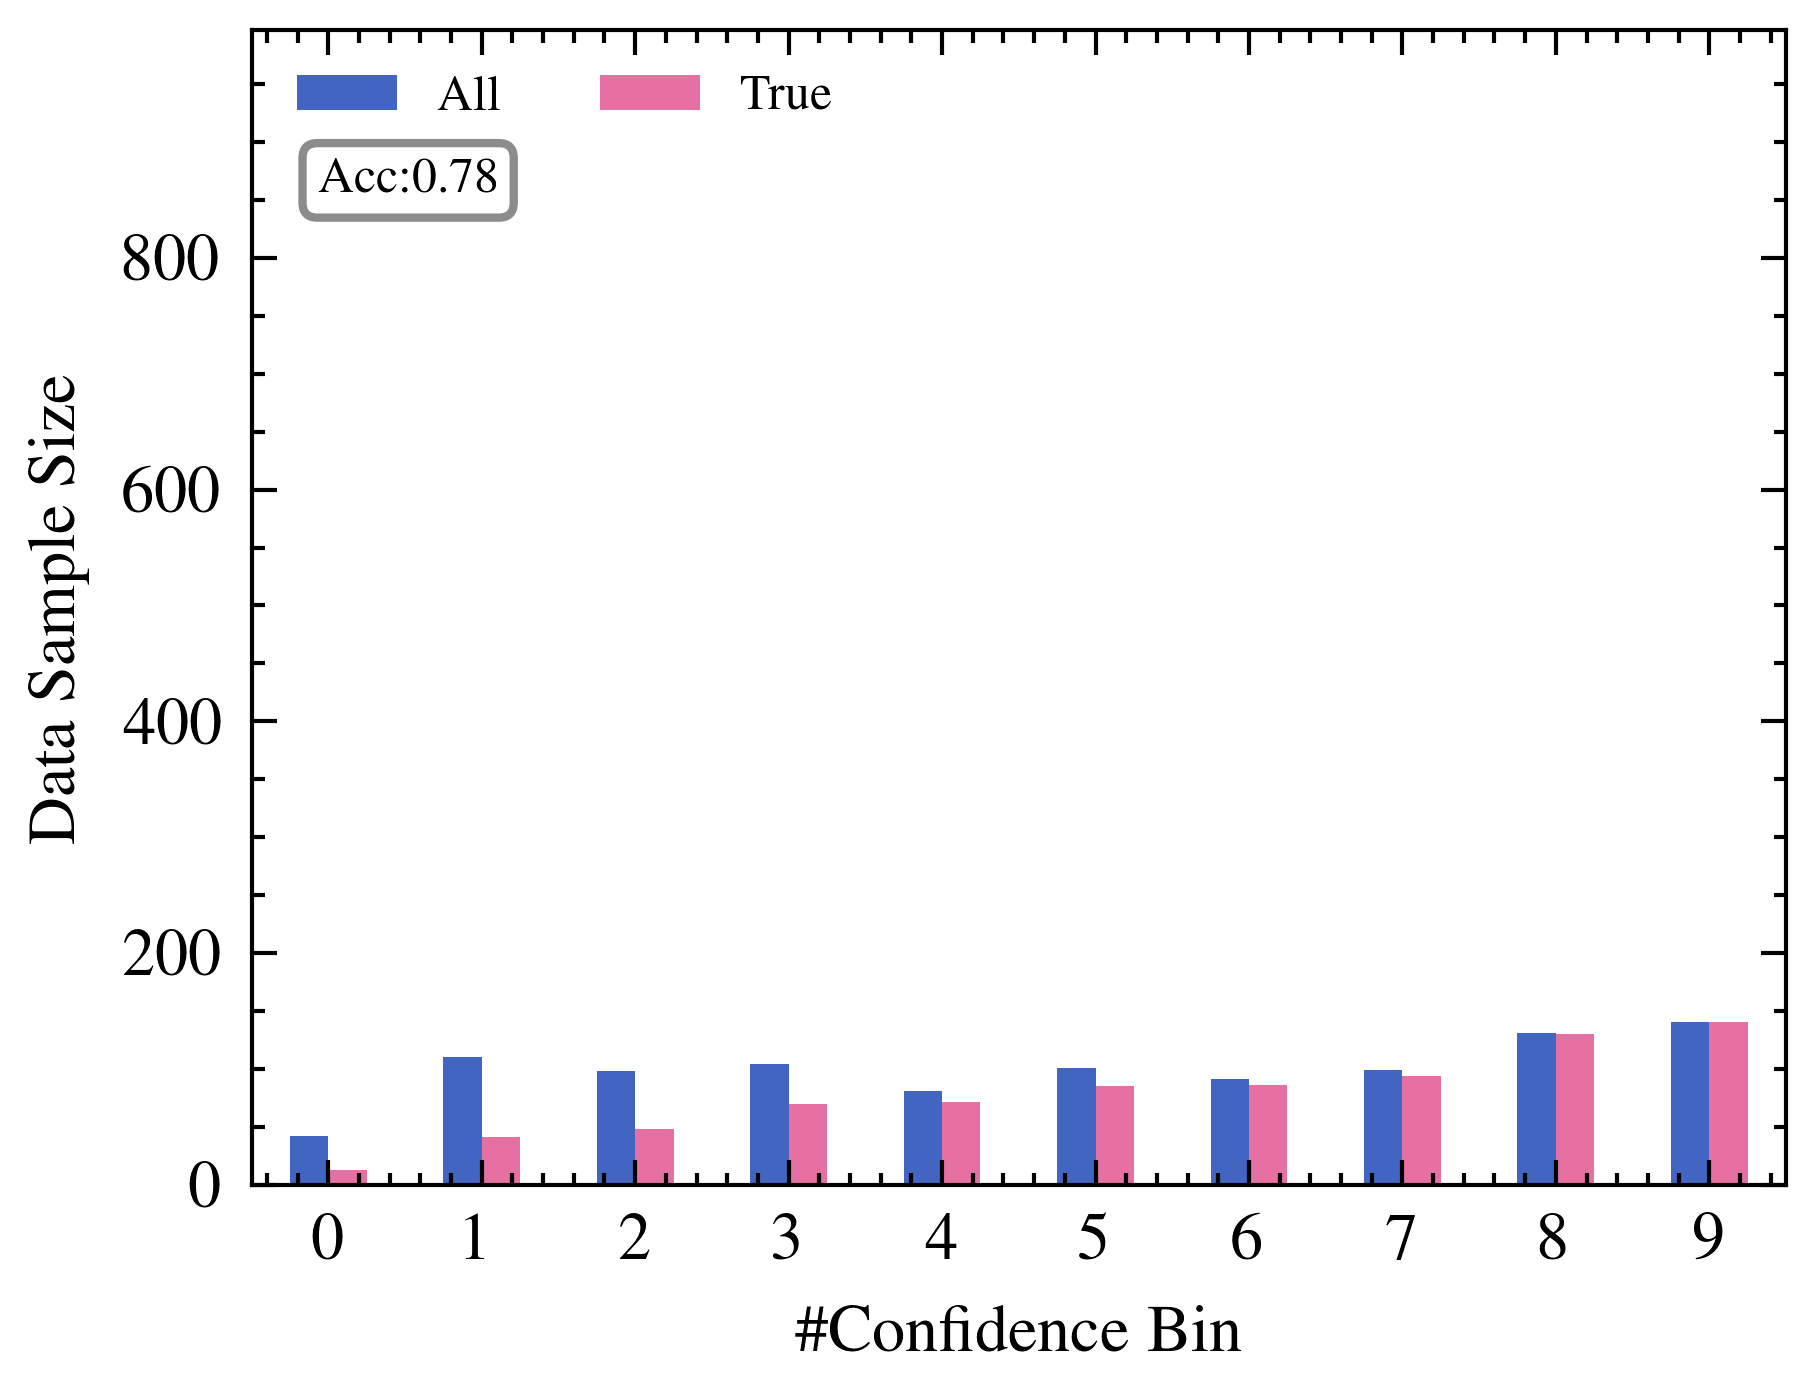

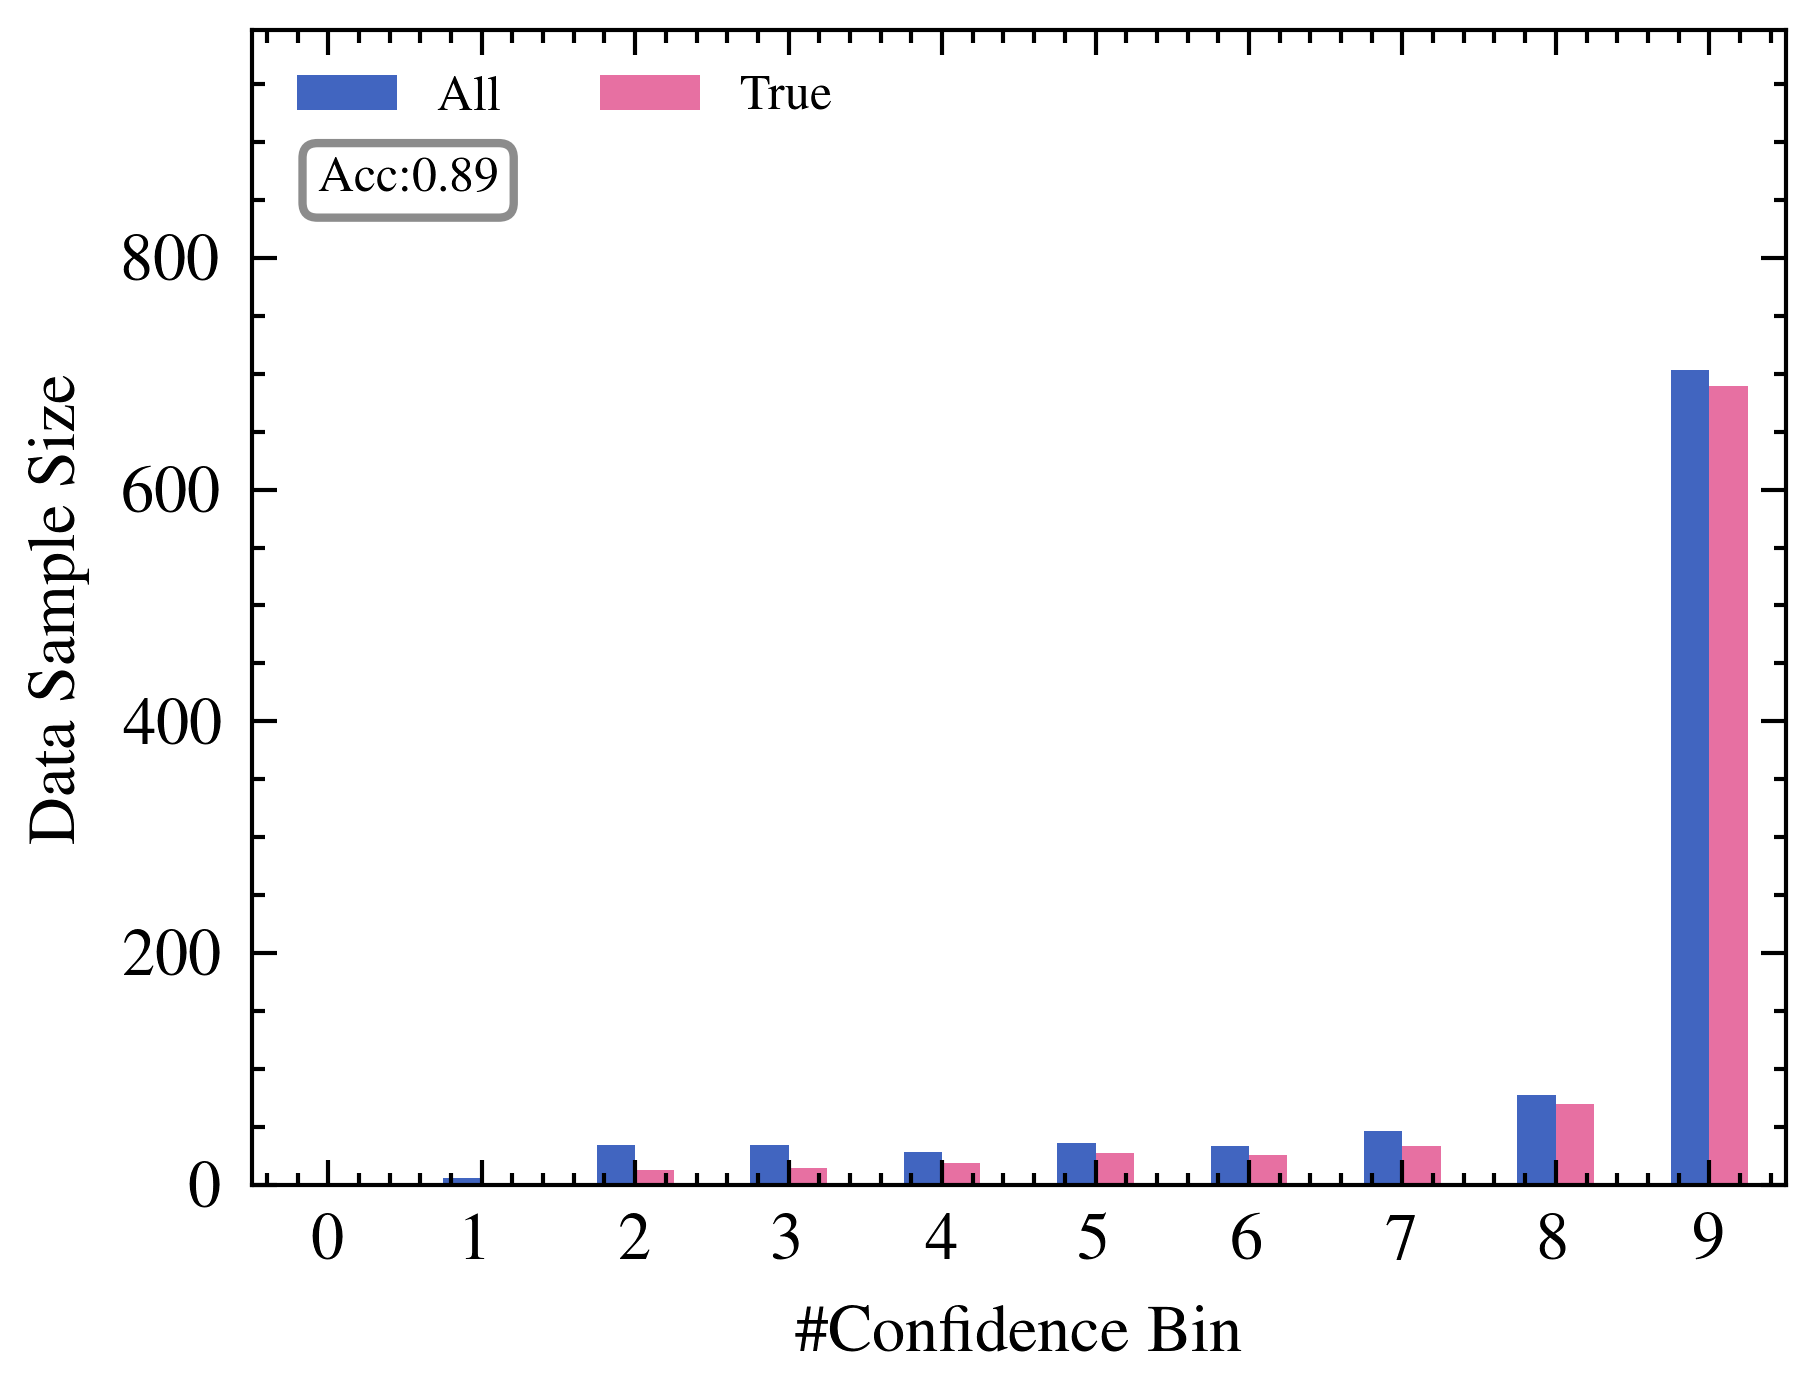

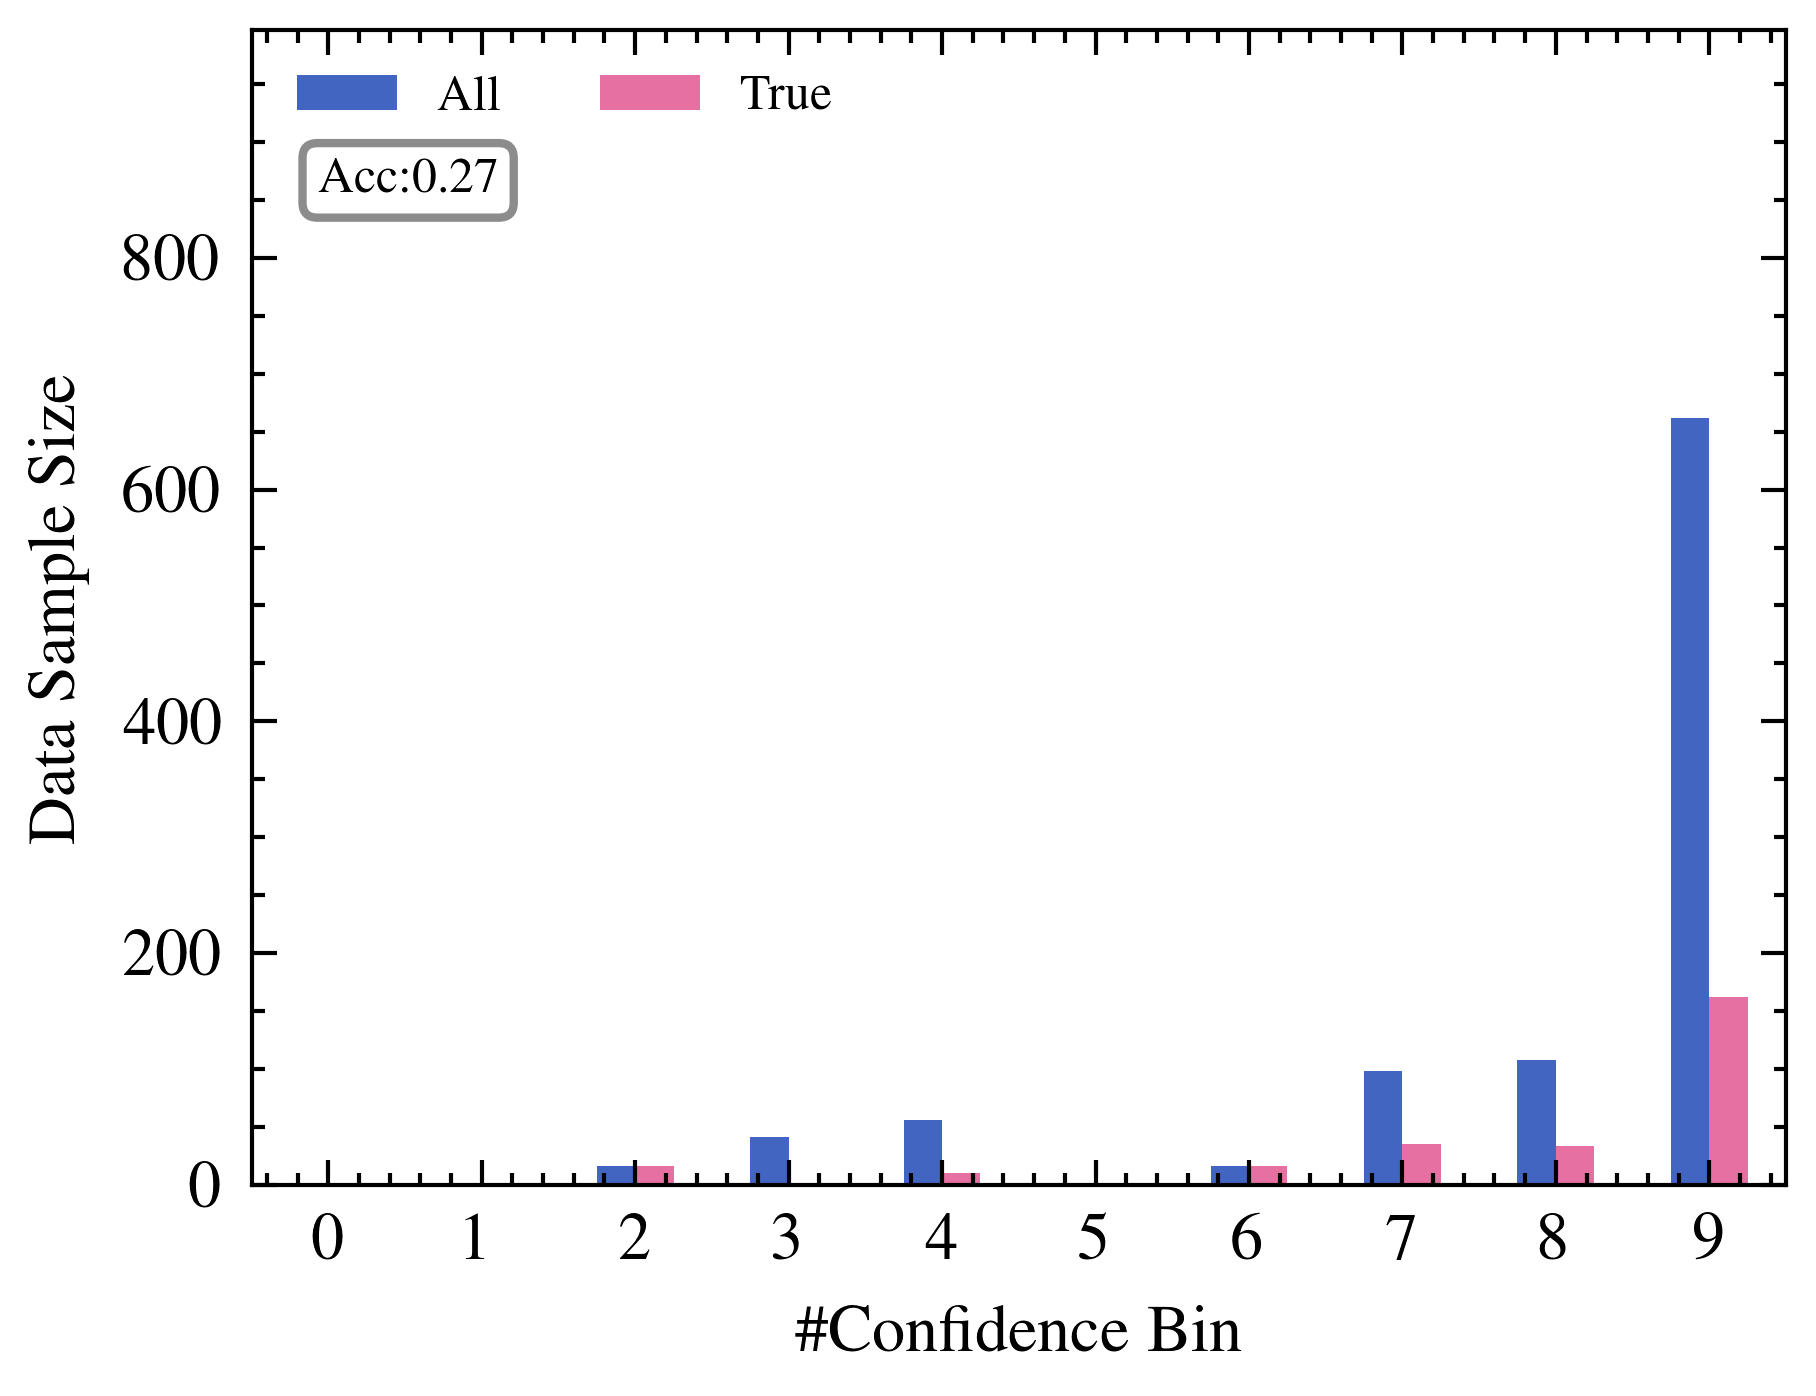

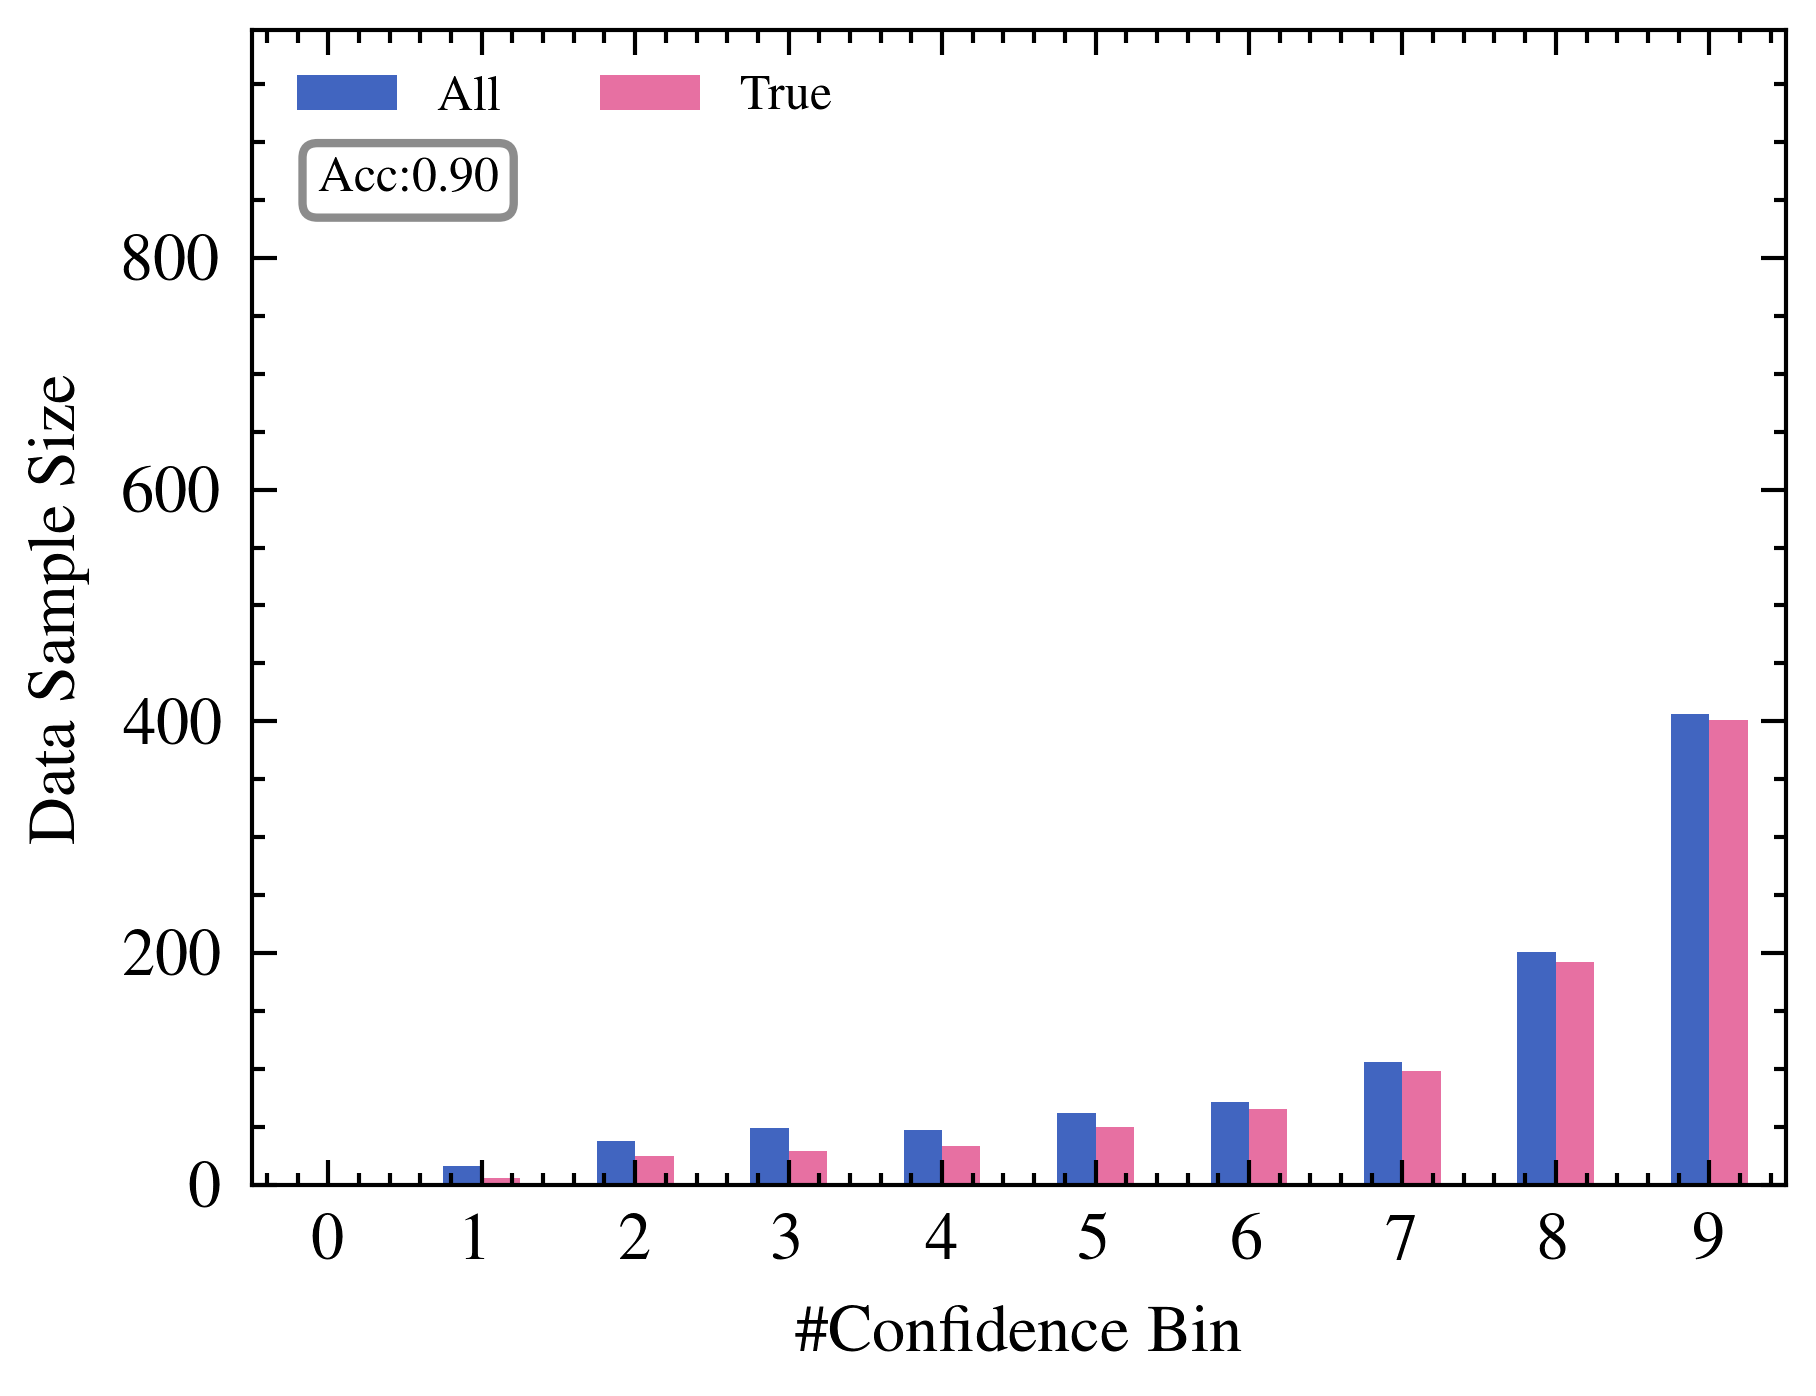

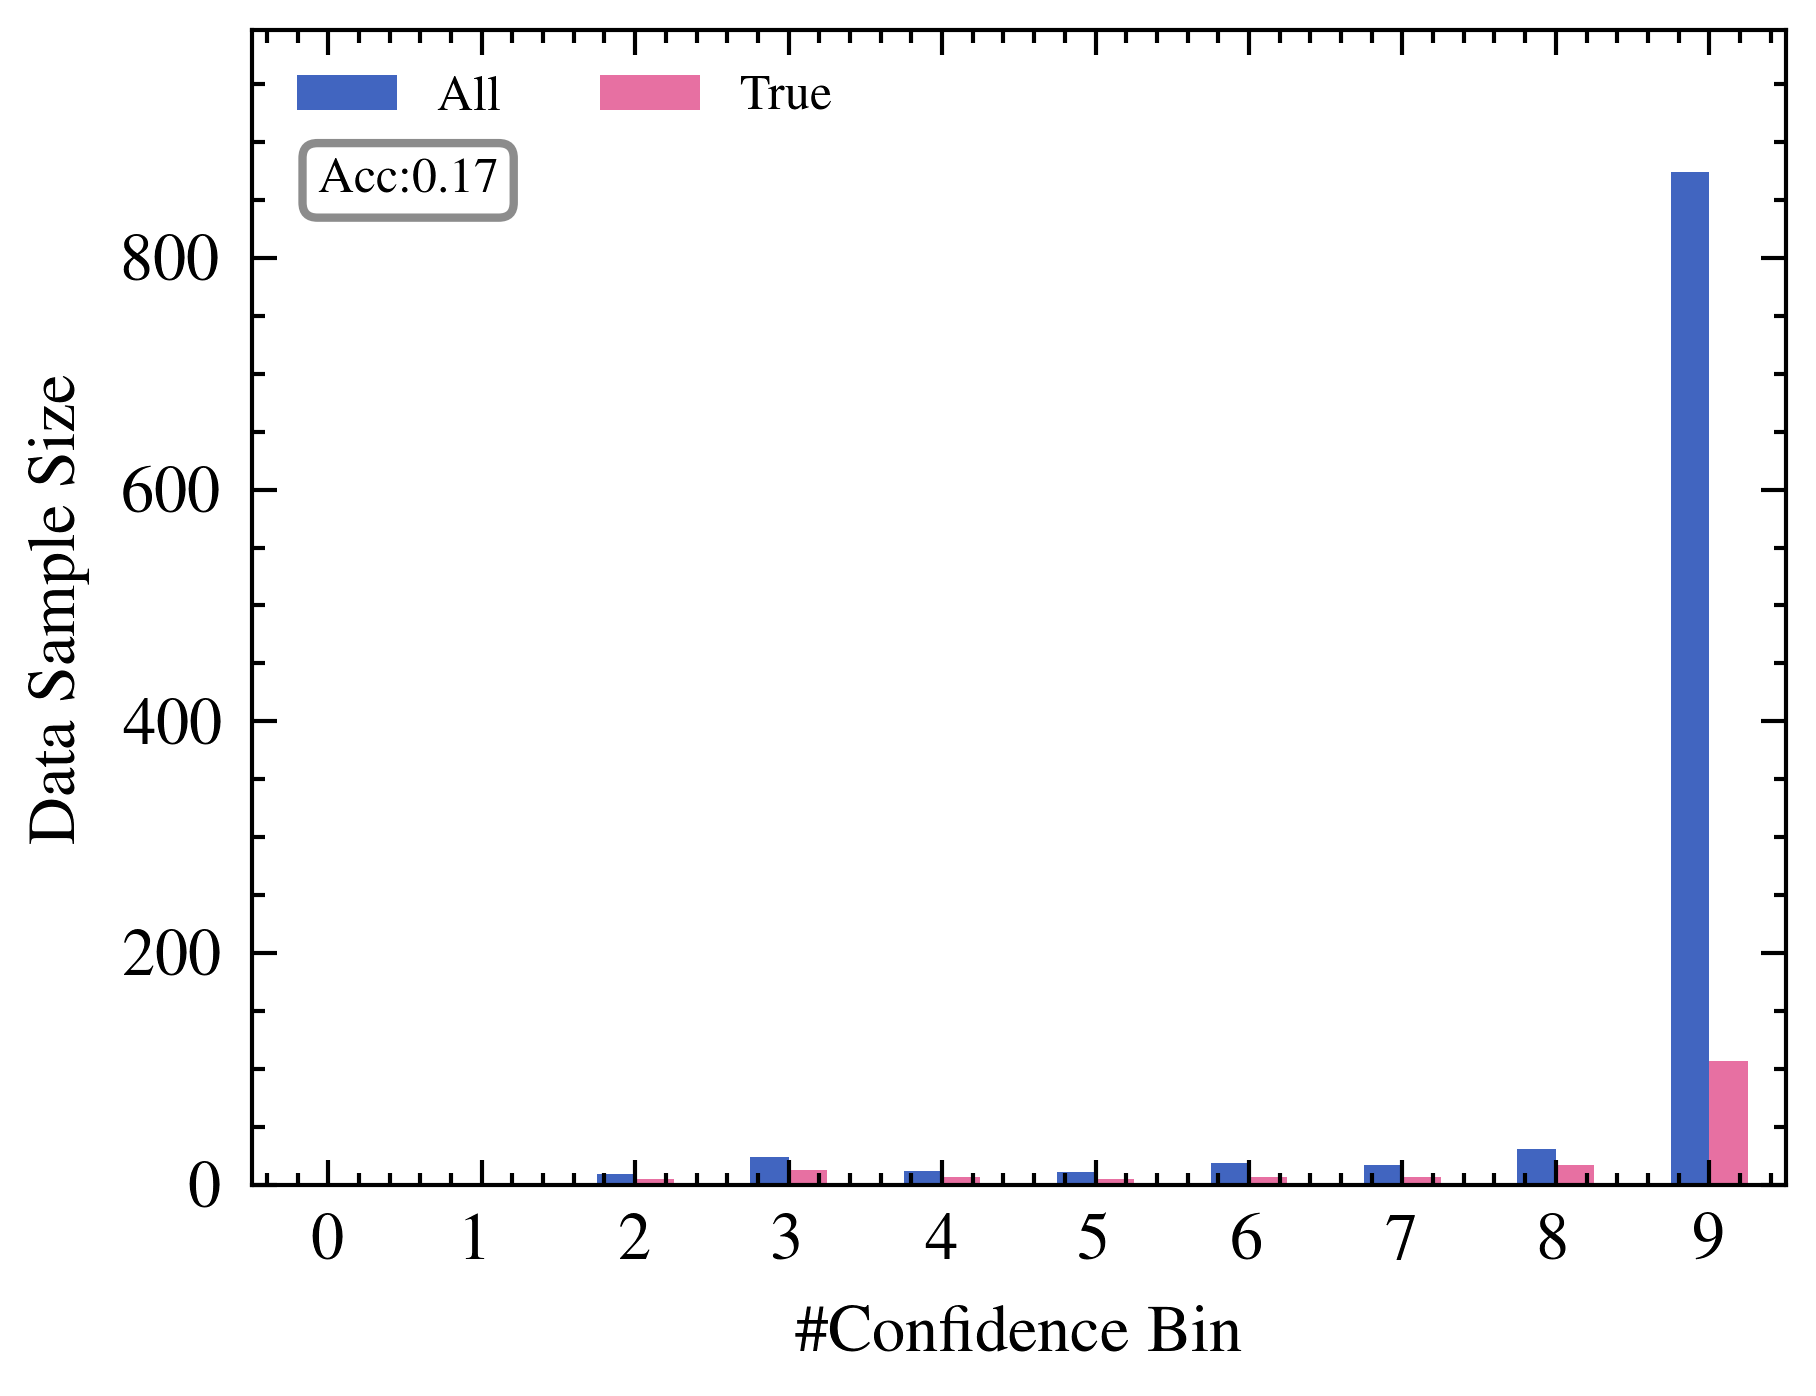

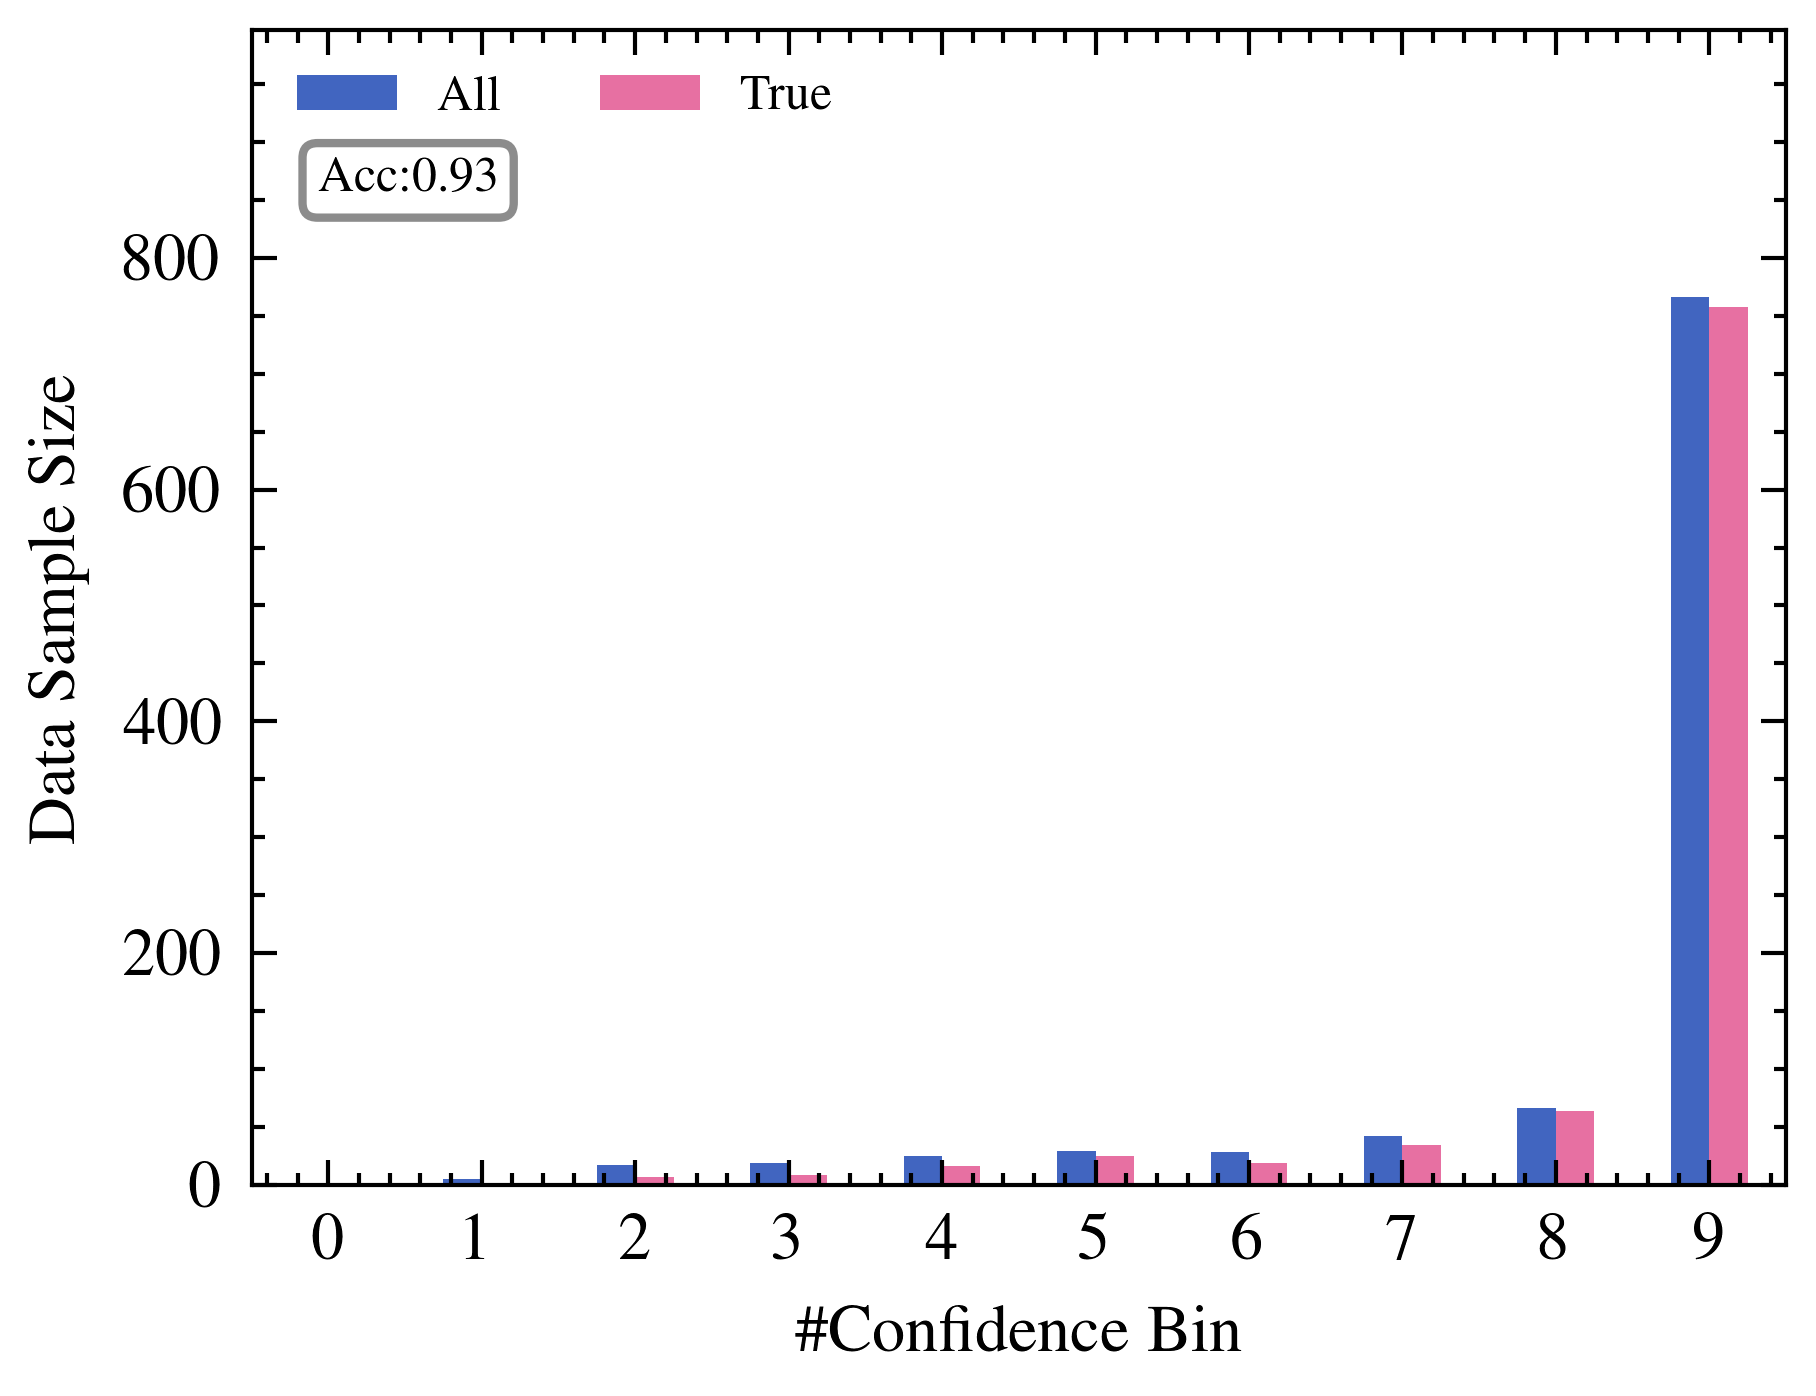

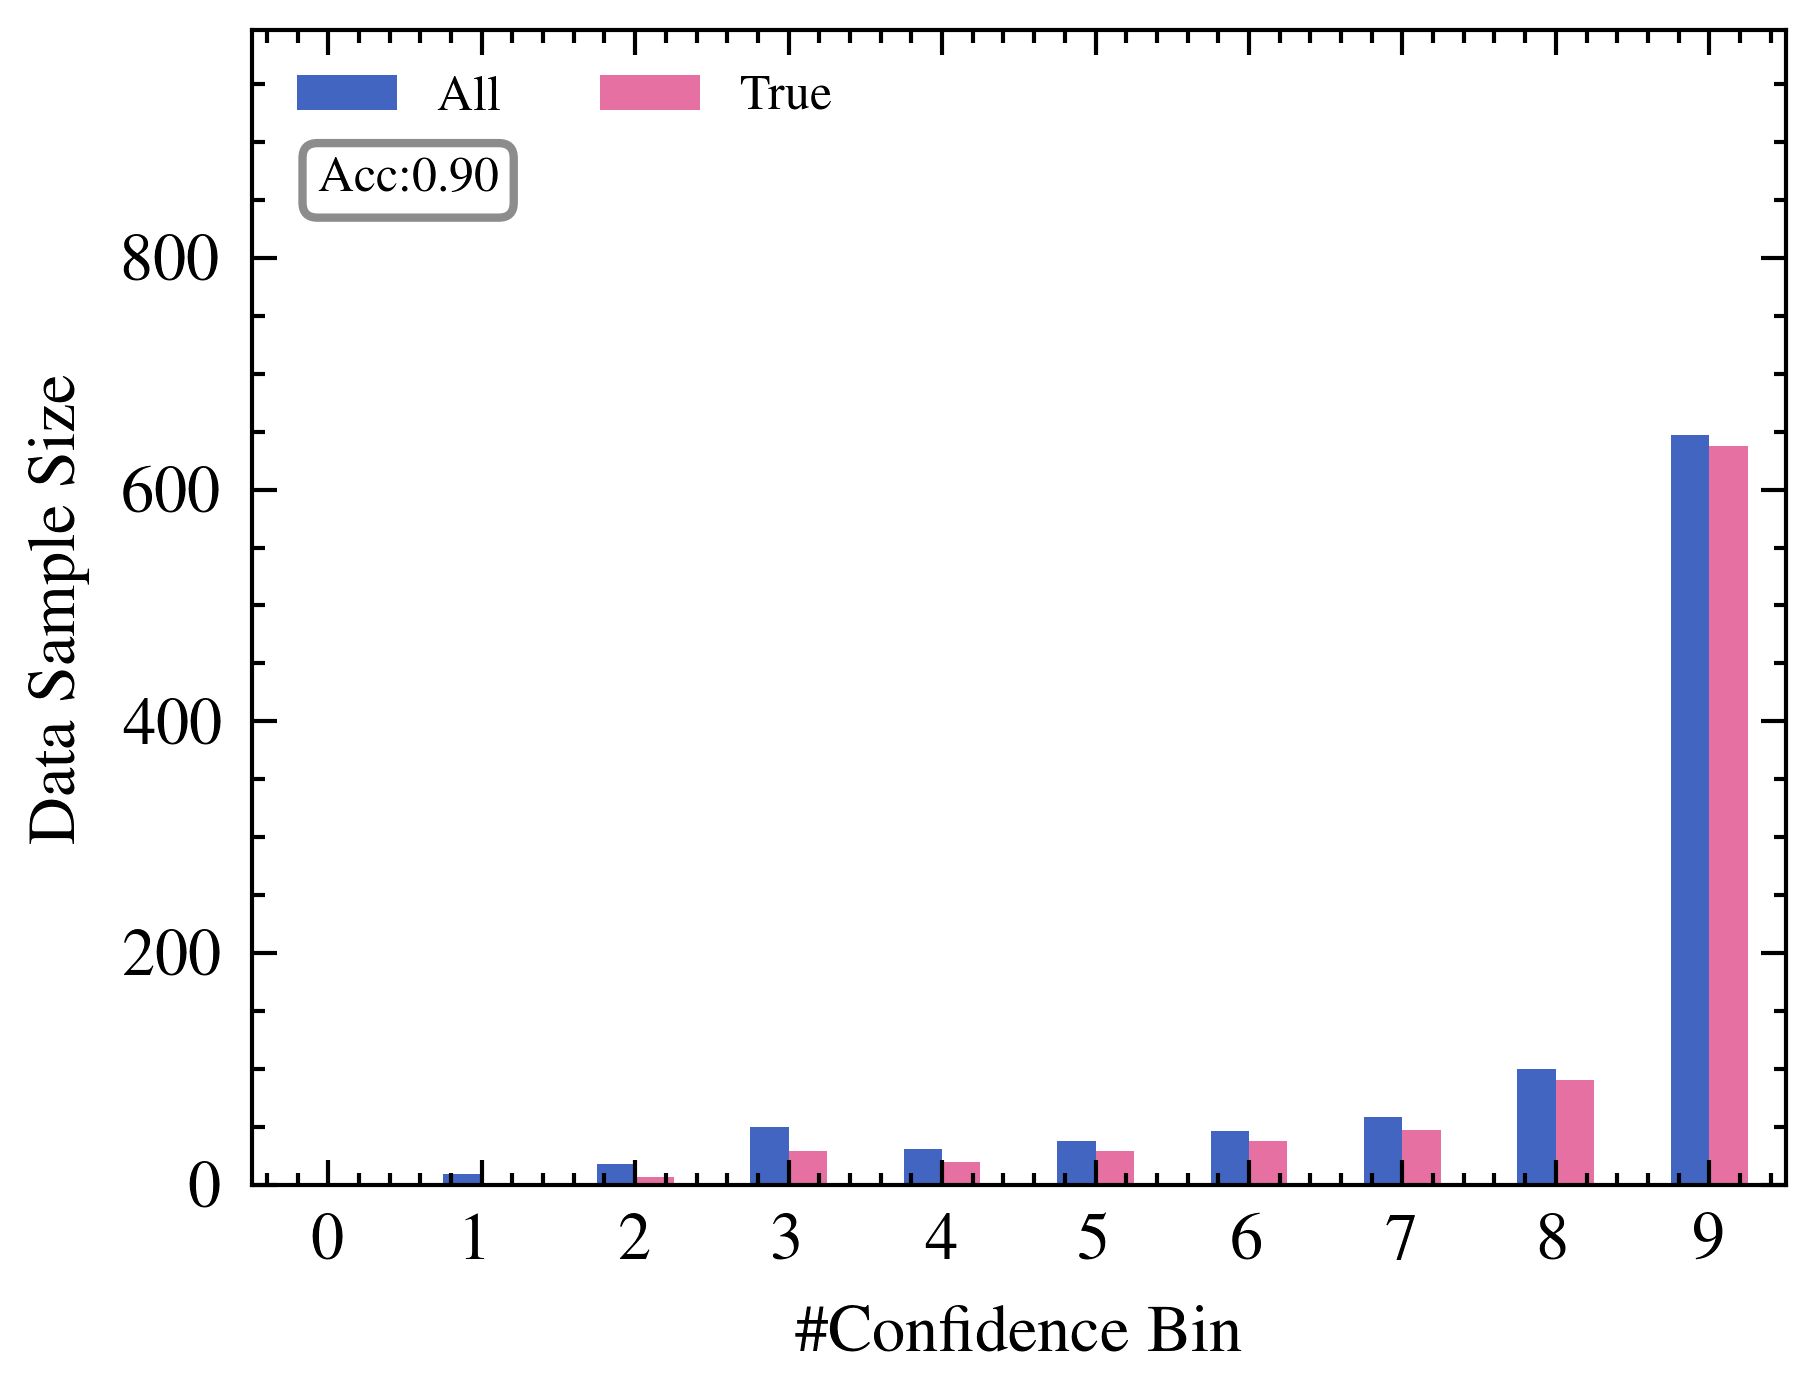

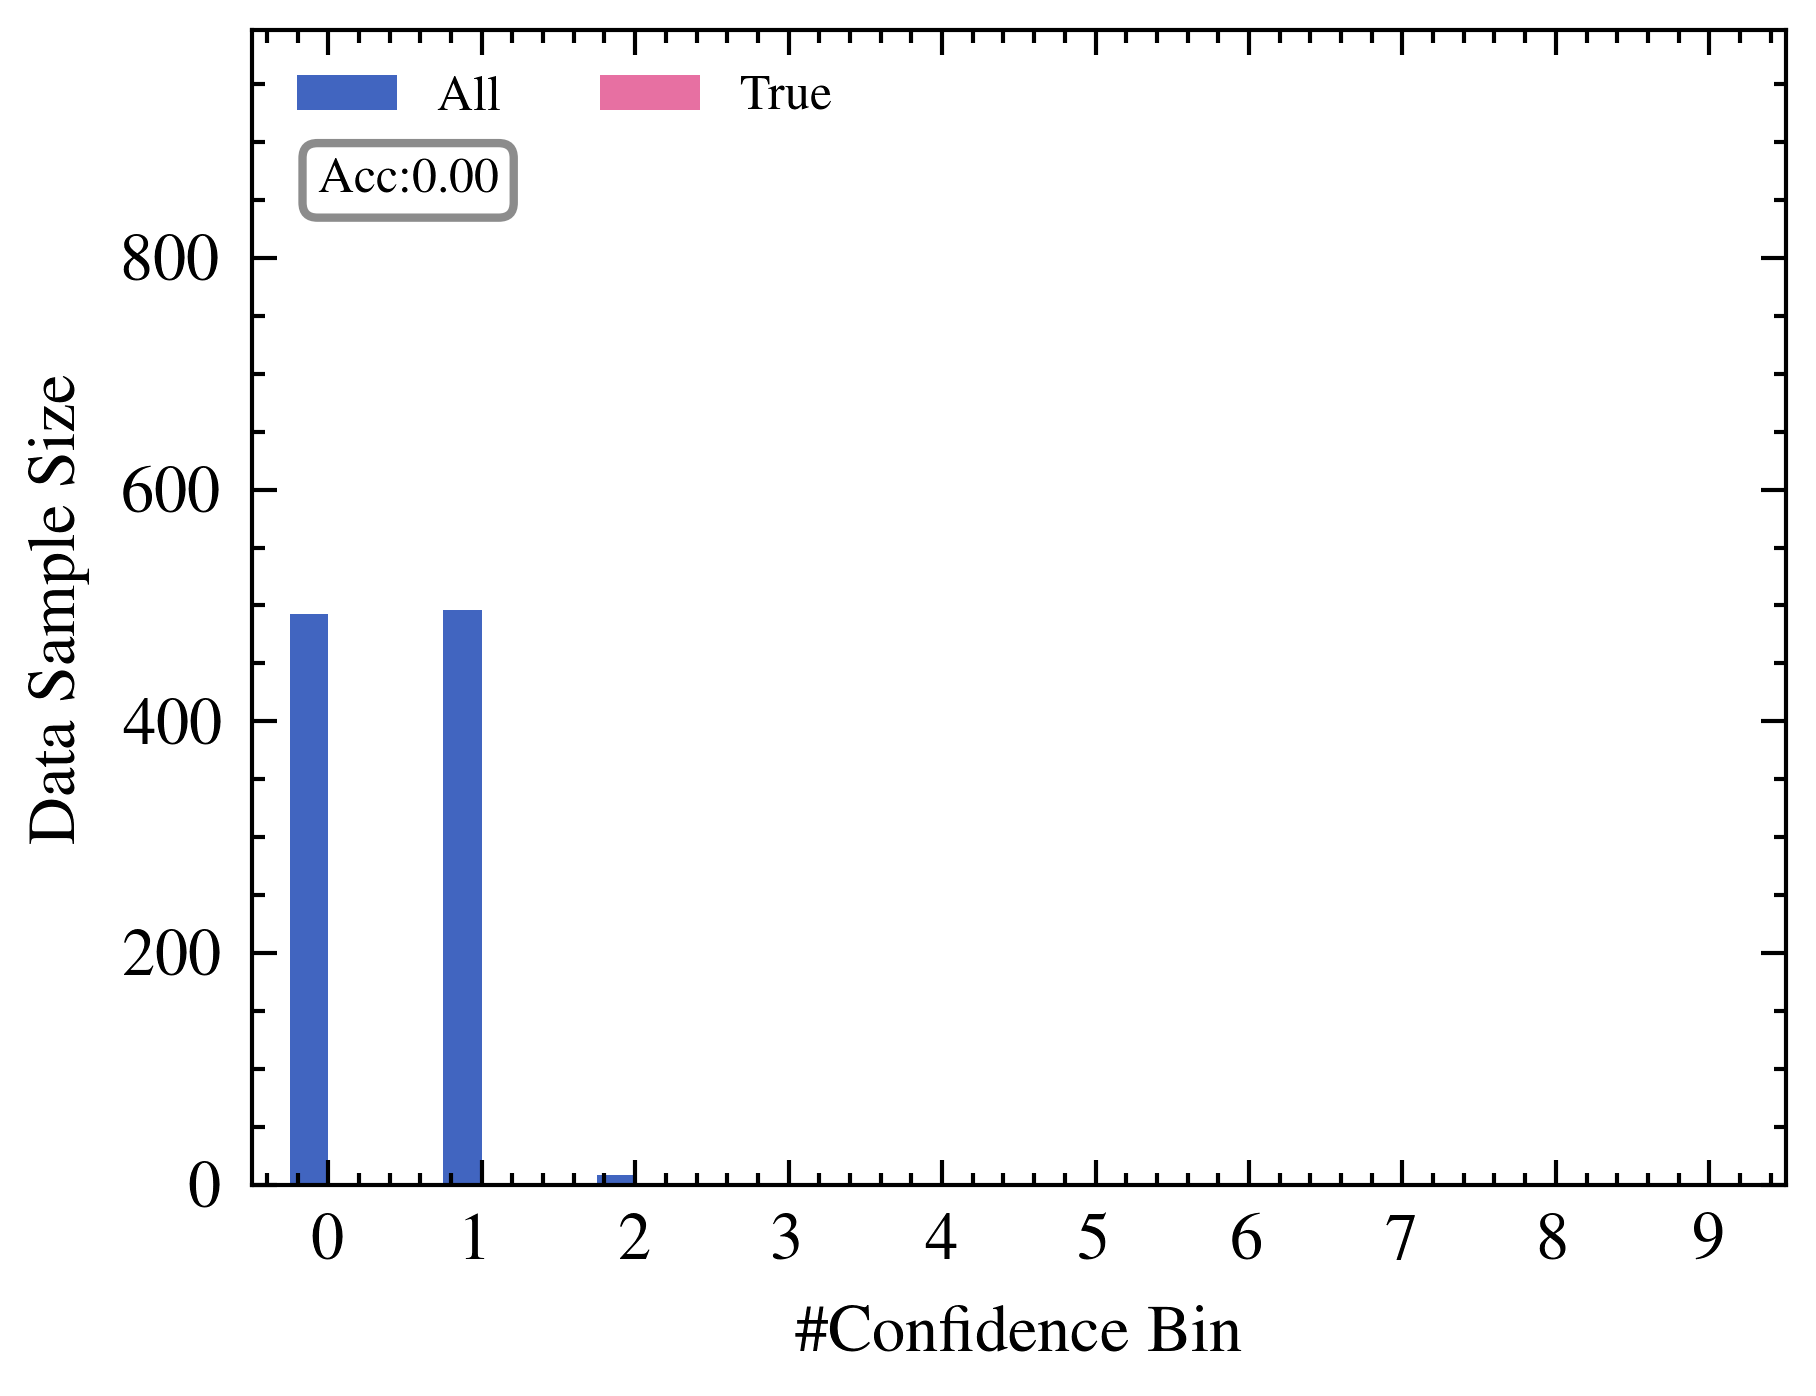

In [121]:
import seaborn as sns
import os
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','retro'])

# fig, ax = plt.subplots()
# ax.set_xlabel('\#Communication rounds')
# ax.set_ylabel('Top-1 Accuracy(\%)')
# data_ds_all.plot(style='.-')
# df_confidence["FedAvg"].plot(kind="bar")
# df_true["FedAvg"].plot(kind="bar")
for ds,name in zip([conf_ori,conf_fedavg,conf_fedrs,conf_moon,conf_fedrod,conf_fedmc,conf_fedbalance,conf_fedbalance_local],["Origin","FedAvg","FedRS","MOON","FedRoD","FedMC","FedBalance","local"]):
    ds.index = ["All","True"]
    ds.T.plot(kind="bar")
    plt.xlabel('\#Confidence Bin')
    plt.ylabel('Data Sample Size')
    plt.ylim((0,ds.loc["All"].sum() ))
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    plt.text(-0.07, ds.loc["All"].sum()-140, "Acc:{:.2f}".format(+ds.loc["True"].sum()/ds.loc["All"].sum()),fontdict={"size":6,"weight":"bold"},bbox =bbox_props)
    plt.xticks(rotation=0) # 旋转90度
    # plt.title(name)
    # sns.barplot(data = df_confidence)
    plt.legend(loc="upper left",ncol= 2,fontsize=6)
    plt.savefig(name+"_inter-class.pdf",dpi = 300)
    plt.show()

In [ ]:
data_all_clients_list_mean = pandas.DataFrame()

for df in data_all_clients_list:
    data_all_clients_list_mean = pandas.concat([data_all_clients_list_mean,df.mean()],axis=1)

print(len(data_all_clients_list))   
print(data_all_clients_list_mean.T.reset_index().drop(columns=["index"]).mean())

10
Origin        0.614098
FedAvg        0.398646
FedRS         0.100216
MOON          0.165625
FedBalance    0.419450
dtype: float32


In [ ]:
print(client_infos) #1

info = client_infos[1]
        # print(client_infos)

cnts = []
for c in range(10):
    if c in info.keys():
        num = info[c]
    else:
        num = 0
    cnts.append(num)

cnts = numpy.array(cnts)

data_info = pandas.Series(cnts/cnts.sum()).to_frame("Local Info")

In [ ]:
print(data_ds_all)

Empty DataFrame
Columns: []
Index: []


In [ ]:
import seaborn as sns
import os
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','retro'])

# fig, ax = plt.subplots()
# ax.set_xlabel('\#Communication rounds')
# ax.set_ylabel('Top-1 Accuracy(\%)')
data_ds_all.plot(style='.-')
data_info.plot(kind="bar")
plt.xlabel('\#Labels')
plt.ylabel('Top-1 Accuracy(\%)')
plt.xticks(rotation=0) # 旋转90度
# sns.barplot(y = data_ds_all.columns,data = data_ds_all.T)
plt.legend(loc="upper right",ncol= 2,fontsize=6)
plt.savefig("motivation_cifar10"+".pdf",dpi = 300)
plt.show()

TypeError: no numeric data to plot

In [ ]:
data_ds_diff = pandas.DataFrame()

for name in ['FedAvg', 'FedRS', 'FedBalance',"MOON"]:
    data_ds_diff[name]=data_ds_all[name]-data_ds_all["Origin"]

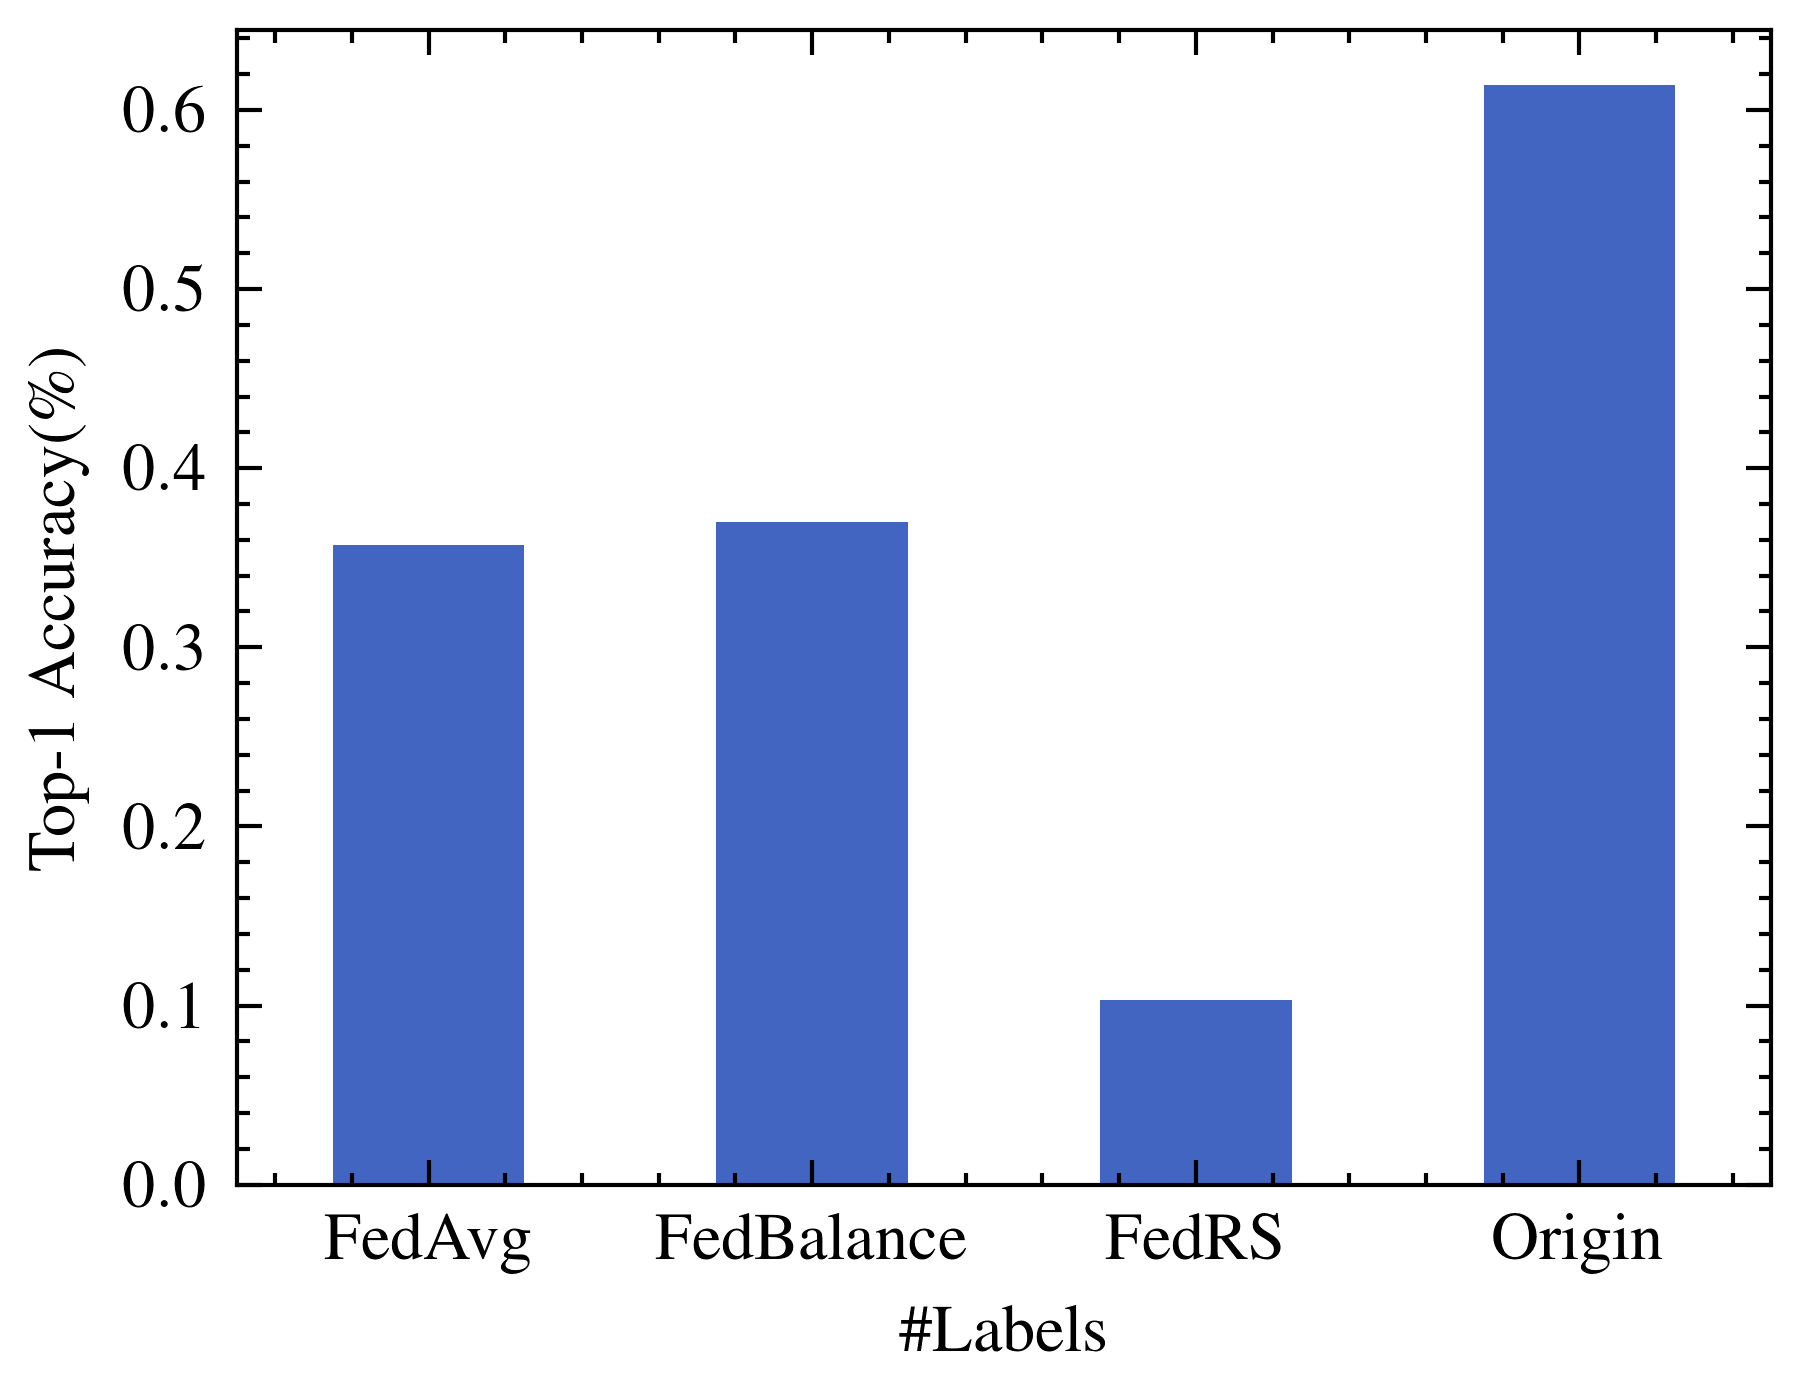

In [ ]:
import seaborn as sns
import os
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','retro'])

# fig, ax = plt.subplots()
# ax.set_xlabel('\#Communication rounds')
# ax.set_ylabel('Top-1 Accuracy(\%)')
data_ds_all.mean().plot(kind="bar")
# data_info.plot(kind="bar")
plt.xlabel('\#Labels')
plt.ylabel('Top-1 Accuracy(\%)')
plt.xticks(rotation=0) # 旋转90度
# sns.barplot(y = data_ds_all.columns,data = data_ds_all.T)
# plt.legend(loc="upper right",ncol= 2,fontsize=6)
plt.savefig("motivation_cifar10"+".pdf",dpi = 300)
plt.show()

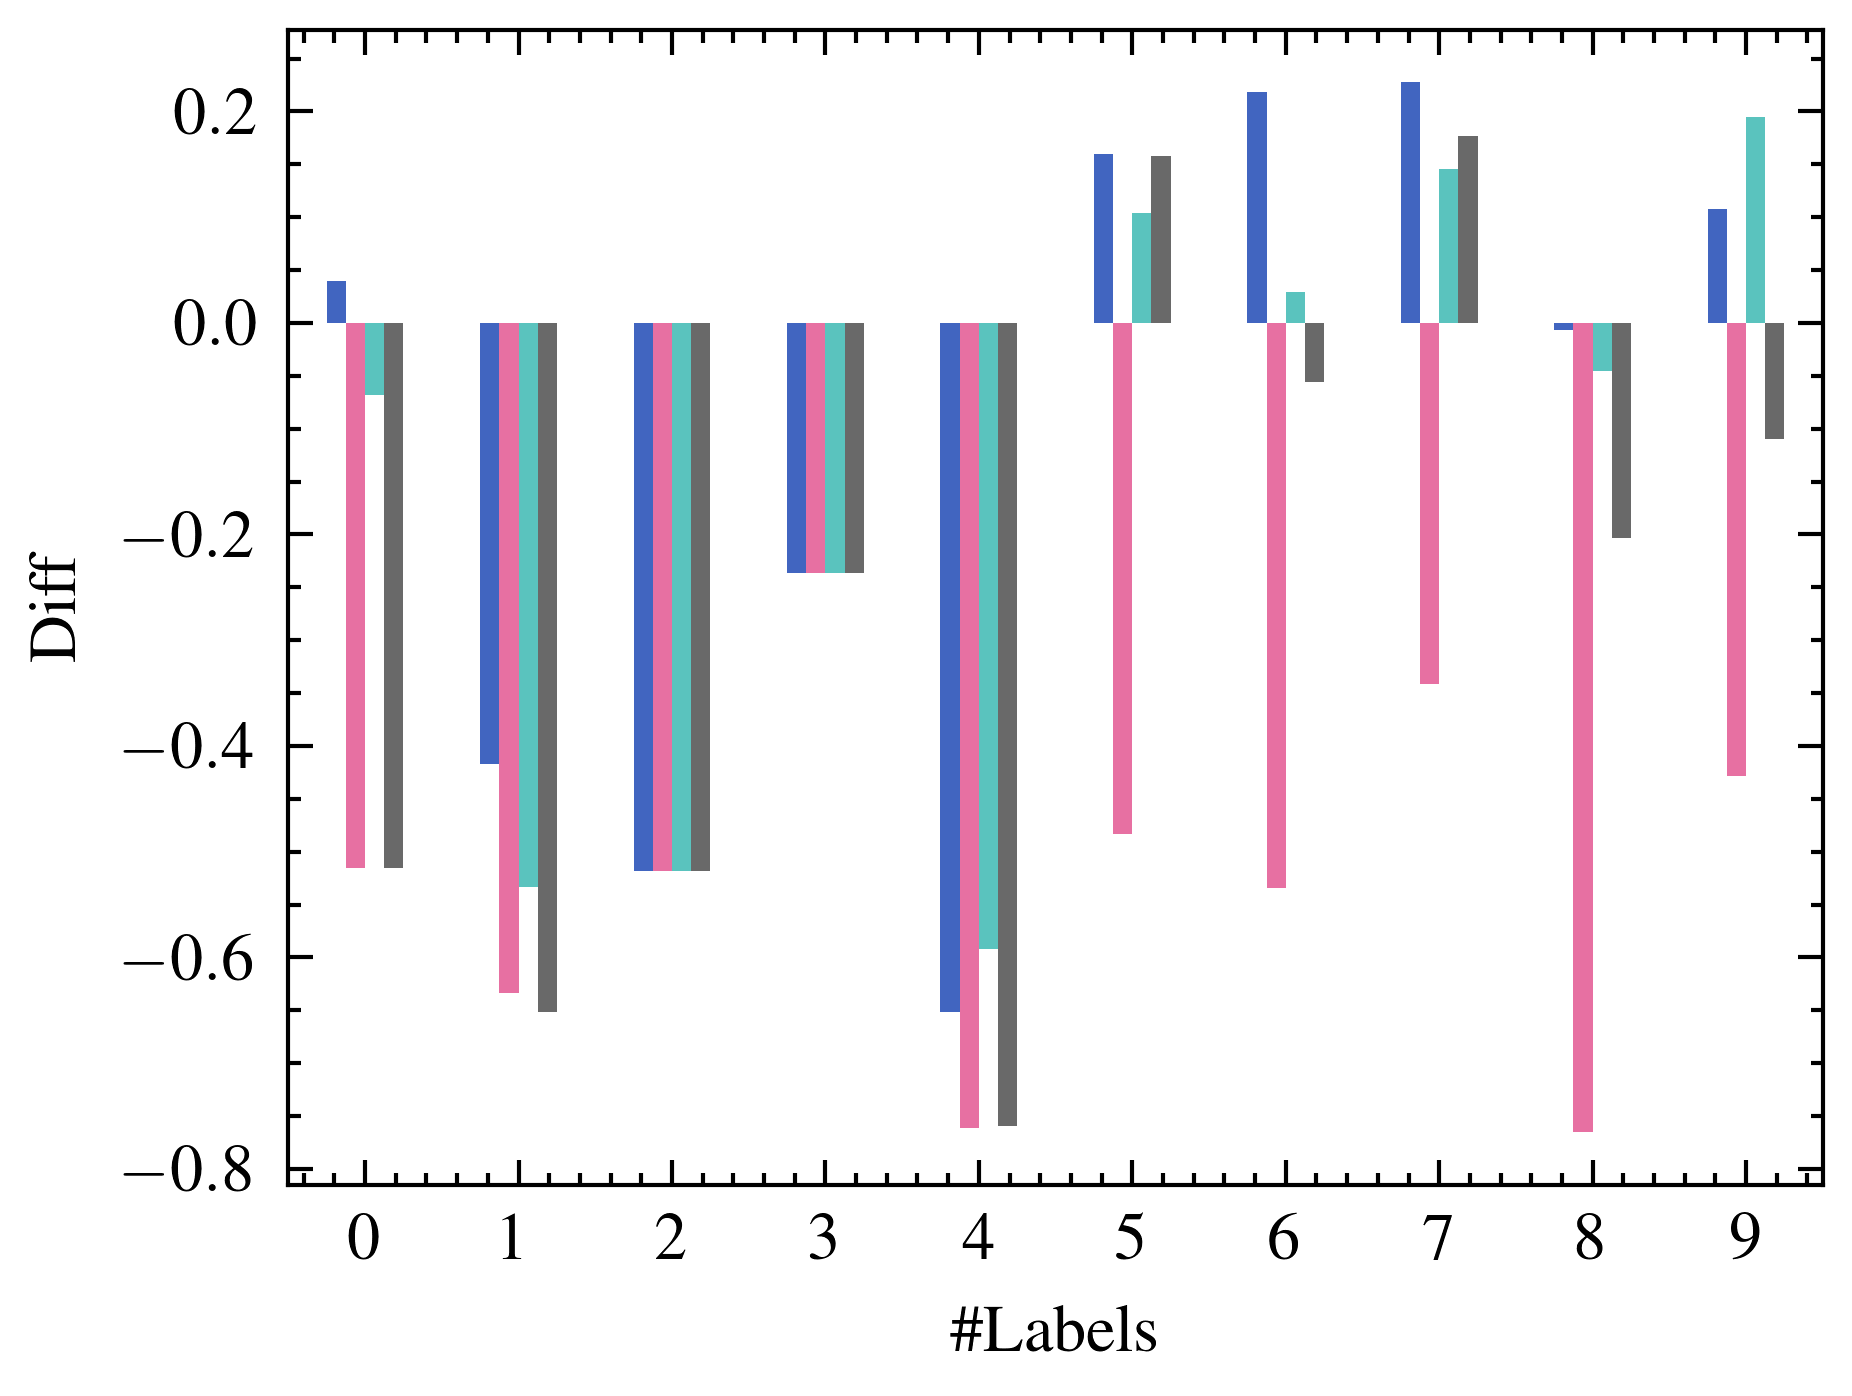

In [ ]:
import seaborn as sns
import os
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','retro'])

fig, ax = plt.subplots()
# ax.set_xlabel('\#Communication rounds')
# ax.set_ylabel('Top-1 Accuracy(\%)')
data_ds_diff.plot(kind="bar",ax=ax)
# data_info.plot(kind="bar",ax=ax)
plt.xlabel('\#Labels')
plt.ylabel('Diff')
plt.xticks(rotation=0) # 旋转90度
# sns.barplot(y = data_ds_all.columns,data = data_ds_all.T)
plt.legend(loc="upper right",ncol= 1,fontsize=6)
ax.legend_.remove()
# plt.savefig("motivation_cifar10_client1"+".pdf",dpi = 300)
plt.show()

In [ ]:
# data_ds_all.to_csv("motiv.csv")
print(data_ds_diff.mean())
data_ds_diff_abs = data_ds_diff.abs()
print(data_ds_diff_abs.mean())
print(data_ds_diff_abs.std())
# data_info.to_csv("info.csv")

FedAvg       -0.107843
FedRS        -0.521666
FedBalance   -0.152028
MOON         -0.271652
dtype: float32
FedAvg        0.258491
FedRS         0.521666
FedBalance    0.246778
MOON          0.338452
dtype: float32
FedAvg        0.209278
FedRS         0.167811
FedBalance    0.218225
MOON          0.249006
dtype: float32


/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


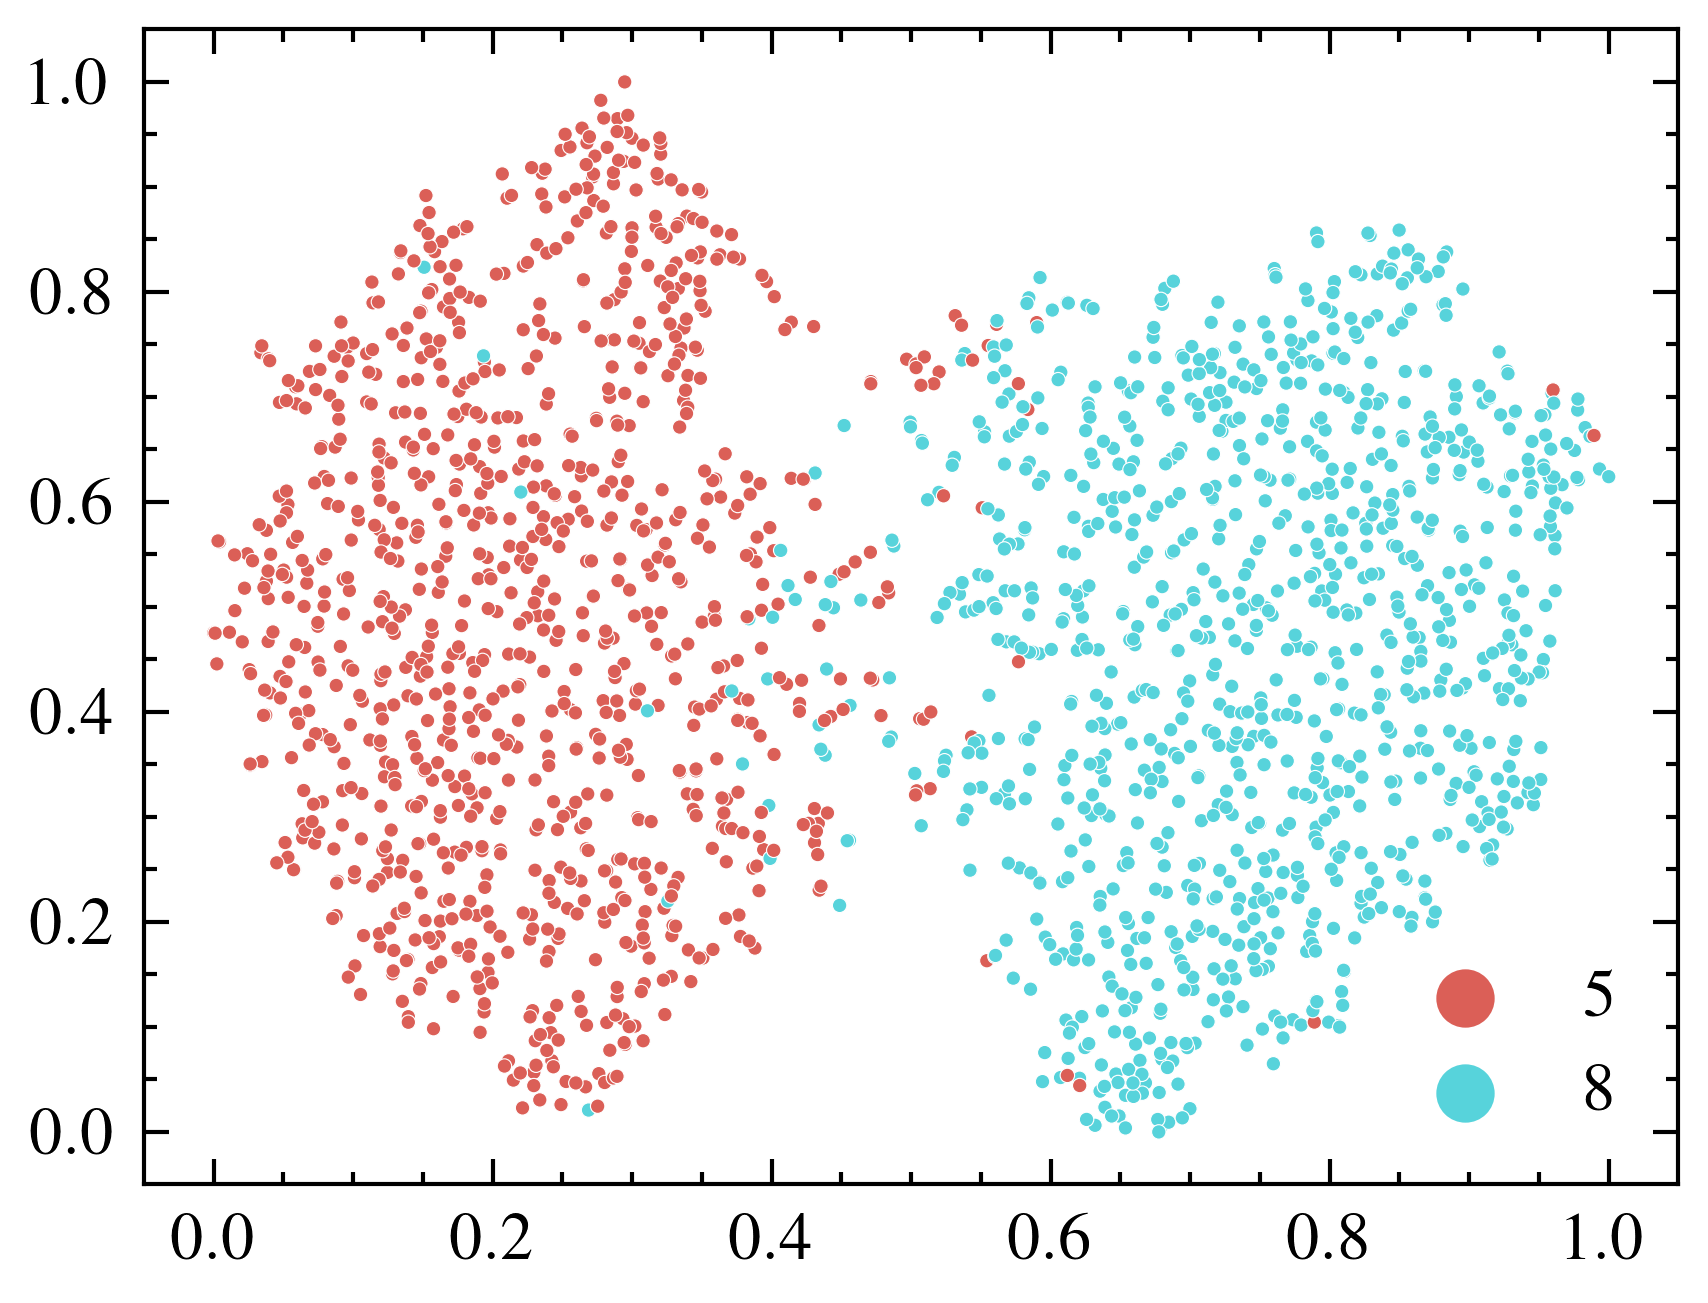

In [111]:
def eval_df_tsne():
    model = load_ori_model(KD=True)

    model.eval()

    features = None
    labes = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            h, _ = model(x)

            if features is None:
                features = h.cpu()
                labes = target.cpu()
            else:
                features = torch.concat((features, h.cpu()), dim=0)
                labes = torch.concat((labes, target.cpu()), dim=0)
    # a=  ()
    features = features[(labes==8)|(labes==5)]
    from sklearn import manifold
    from matplotlib import pyplot as plt
    import seaborn as sns
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
    X_tsne = tsne.fit_transform(features)
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化

    sns.scatterplot(X_norm[:, 0], X_norm[:, 1],s=3,hue=labes[(labes==8)|(labes==5)],palette=sns.color_palette("hls", 2))# hue=labes, s=1,
                    # legend='full', palette=sns.color_palette("hls", 10)
    # plt.legend(loc="upper right",ncol= 3,fontsize=2)
    plt.show()  # return data_temmp


test = eval_df_tsne()


/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


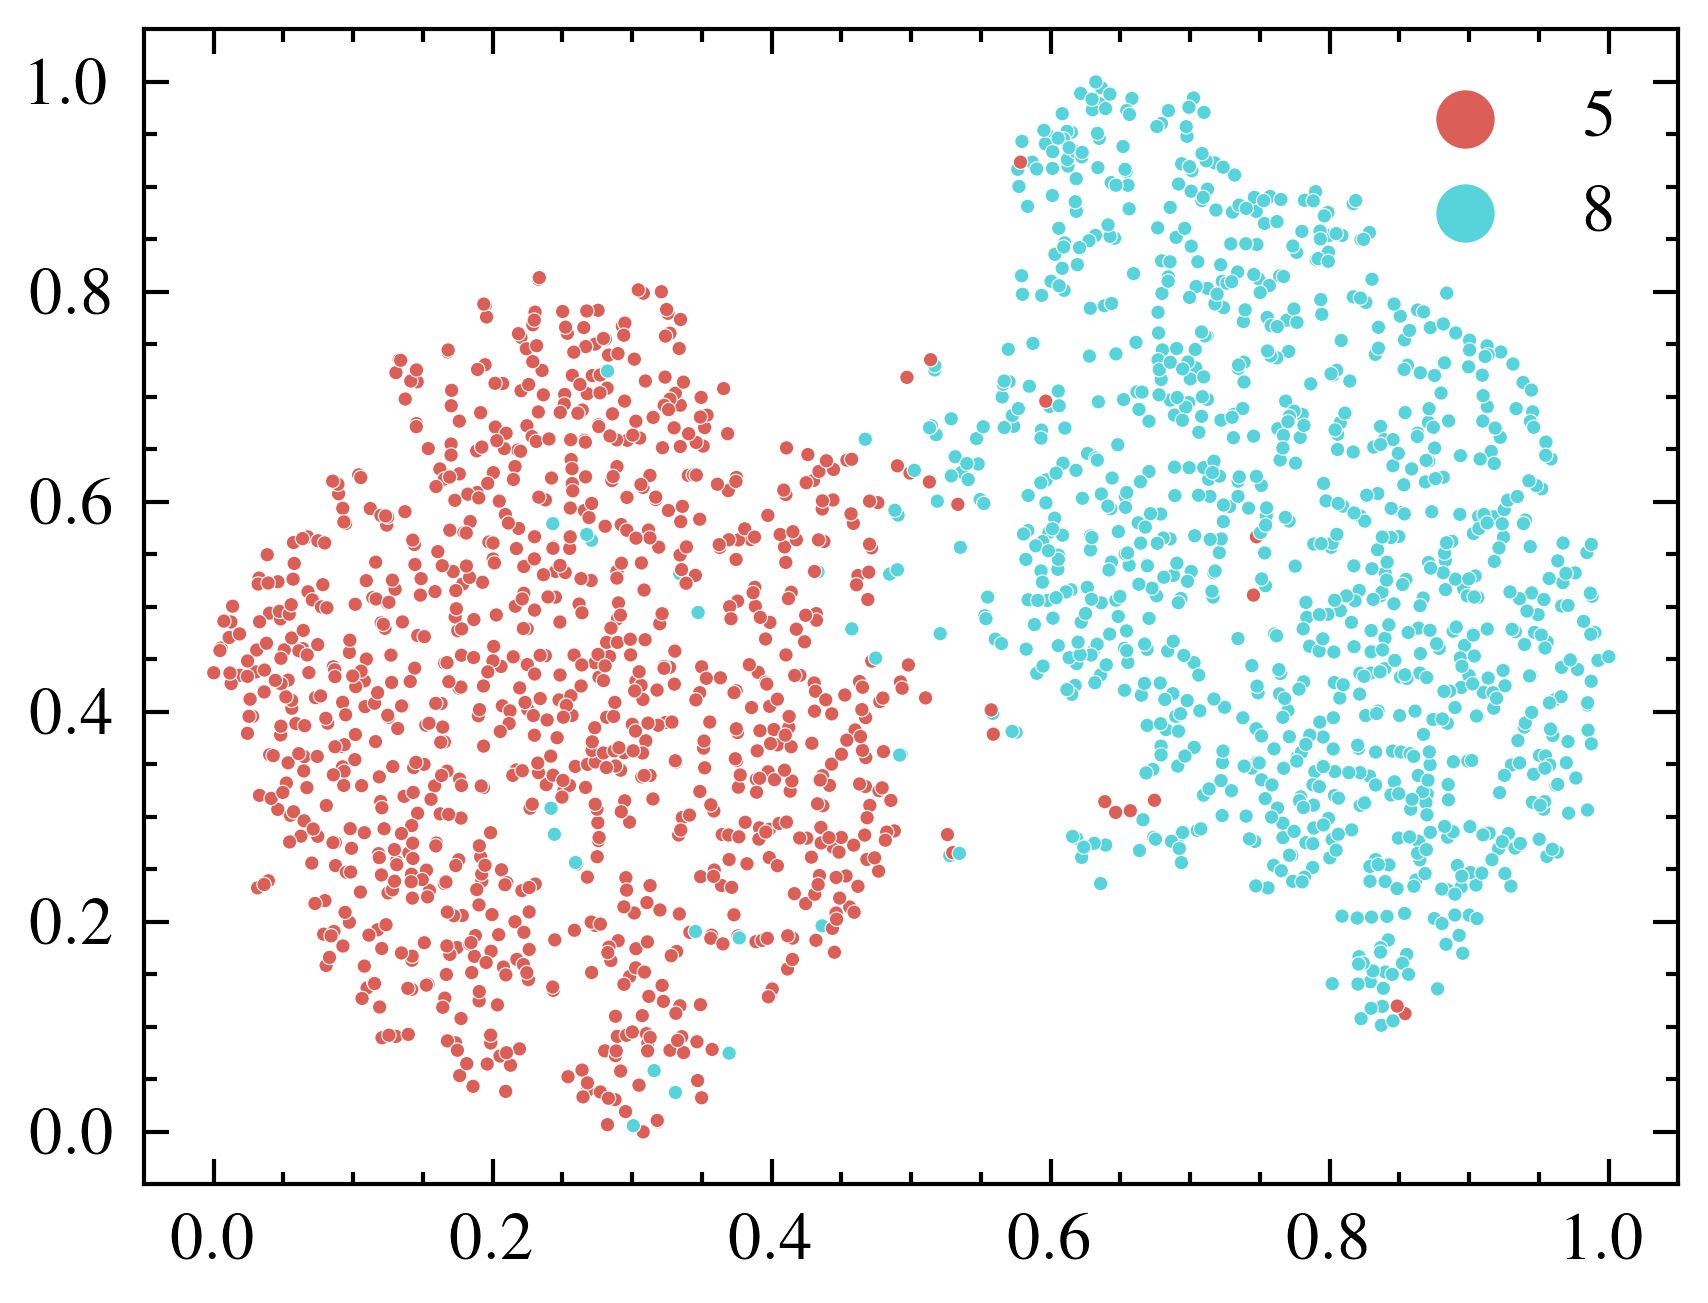

In [114]:
##FedAvg Train&Test
def fedavg_tsne():

    model = load_ori_model(KD=True)

    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            _,log_probs = model(images)
            loss = criterion(log_probs, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
                                                                   

    model.to(device)
    model.eval()

    features = None
    labes = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            h, _ = model(x)

            if features is None:
                features = h.cpu()
                labes = target.cpu()
            else:
                features = torch.concat((features, h.cpu()), dim=0)
                labes = torch.concat((labes, target.cpu()), dim=0)
    # a=  ()
    features = features[(labes==8)|(labes==5)]
    from sklearn import manifold
    from matplotlib import pyplot as plt
    import seaborn as sns
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
    X_tsne = tsne.fit_transform(features)
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化

    sns.scatterplot(X_norm[:, 0], X_norm[:, 1],s=3,hue=labes[(labes==8)|(labes==5)],palette=sns.color_palette("hls", 2))# hue=labes, s=1,
                    # legend='full', palette=sns.color_palette("hls", 10)
    # plt.legend(loc="upper right",ncol= 3,fontsize=2)
    plt.show()  # return data_temmp


test = fedavg_tsne()
# conf_fedavg = fedavg_train_and_test()

0.45637412579620584
0.3733727120301303
0.35851487166741314
0.3498888782718602
0.33240782846422756
0.33726993956986595
0.3228066773975597
0.3274375508813297
0.3206702996702755
0.3113656841656741
0.31169251150944655
0.31779606649104286
0.3057834738317658
0.30973026831360423
0.3040660873055458
0.29853591901414533
0.2856607901699403
0.29584579327527216
0.2867642523611293
0.2773006456739762


/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


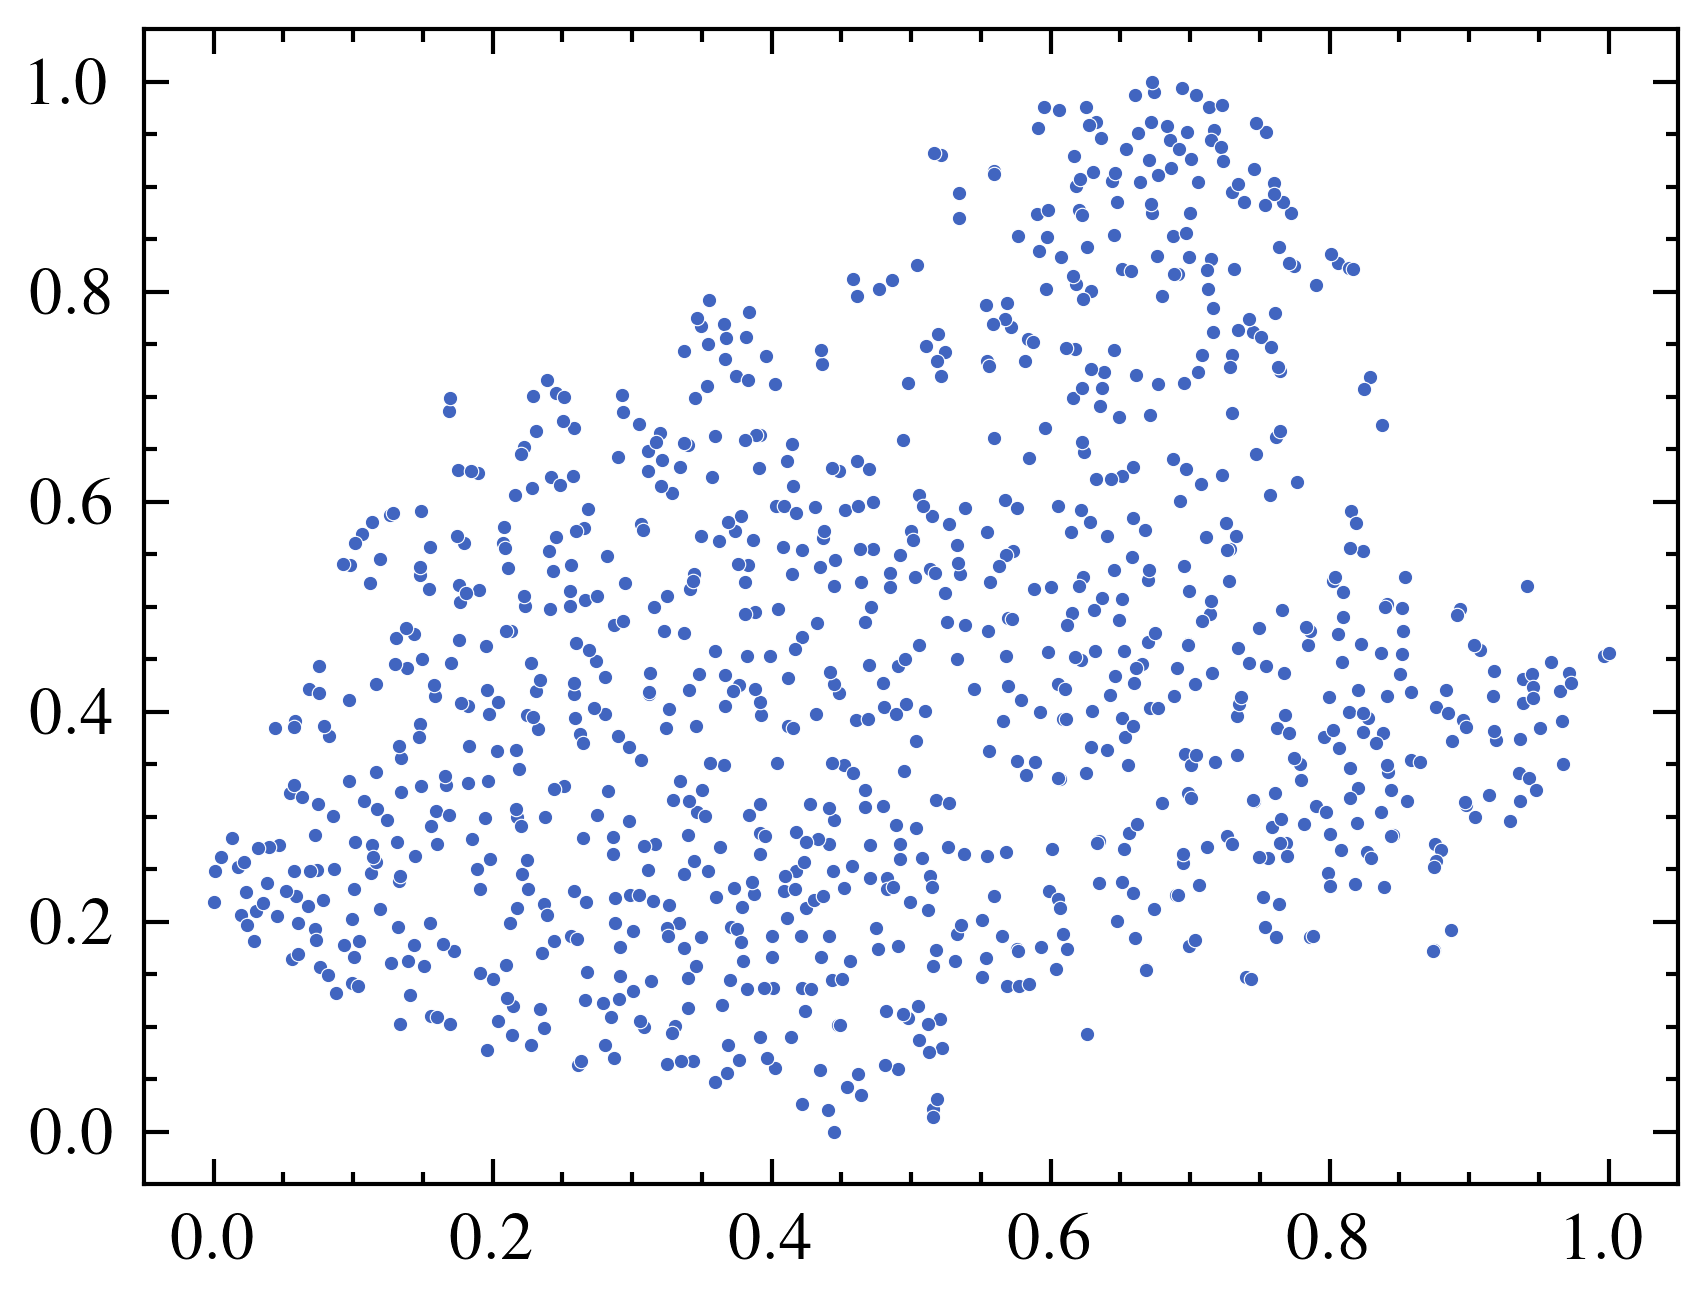

In [116]:
## FedRS Train&Test

def fedrs_tsne(client_idx):
    info = client_infos[client_idx]
            # print(client_infos)

    cnts = []
    for c in range(10):
        if c in info.keys():
            num = 1 
        else:
            num = 0
        cnts.append(num)

    cnts = torch.FloatTensor(numpy.array(cnts))
    # print(cnts)

    cnts = (1-0.5)*cnts+0.5

    cnts = cnts.to(device)

    model = load_ori_model(KD=True)

    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            hs,_ = model(images)
            ws = model.fc.weight

            logits = cnts*hs.mm(ws.transpose(0, 1))
            # log_probs = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        print(numpy.array(batch_loss).mean())

    # model = load_ori_model()

    model.eval()

    features = None
    labes = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            h, _ = model(x)

            if features is None:
                features = h.cpu()
                labes = target.cpu()
            else:
                features = torch.concat((features, h.cpu()), dim=0)
                labes = torch.concat((labes, target.cpu()), dim=0)
    # a=  ()
    features = features[(labes==8)]
    from sklearn import manifold
    from matplotlib import pyplot as plt
    import seaborn as sns
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
    X_tsne = tsne.fit_transform(features)
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化

    sns.scatterplot(X_norm[:, 0], X_norm[:, 1],s=3,palette=sns.color_palette("hls", 1))# hue=labes, s=1,
                    # legend='full', palette=sns.color_palette("hls", 10)
    # plt.legend(loc="upper right",ncol= 3,fontsize=2)
    plt.show()  # return data_temmp


test = fedrs_tsne(0)
# conf_fedrs = fedrs_train_and_test(0)

In [ ]:
## FedRoD Train&Test

def fedrod_train_and_test(client_idx):
    info = client_infos[client_idx]
            # print(client_infos)

    cnts = []
    for c in range(10):
        if c in info.keys():
            num = info[c]
        else:
            num = 0
        cnts.append(num)

    cnts = torch.FloatTensor(numpy.array(cnts))
    cnts = cnts/cnts.sum()

    model = load_ori_model()

    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            logits = model(images)
            # log_probs = model(images)
            loss = criterion(logits*cnts.to(device), labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        print(numpy.array(batch_loss).mean())

    # model = load_ori_model()

    model.eval()

    preds = None
    labels = None
    confidence = None

    # test_correct = 0.0
    # # test_loss = 0.0
    # test_sample_number = 0.0
    acc = None
    confidences = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            # pred = model(x)
            
            logits = model(x)

            probs = torch.softmax(logits,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<=end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds== 8)).float().sum()
        # confidence_bin_false = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    return data_temmp
    # for c in range(10):
    #     temp_confidece = (((preds == labels) * (labels == c)* confidence) / (max((labels == c).sum(), 1))).sum().cpu()
    #     temp_acc = (((preds == labels) * (labels == c)).float() / (max((labels == c).sum(), 1))).sum().cpu()
    #     if acc is None:
    #         acc = temp_acc.reshape((1,-1))
    #         confidences = temp_confidece.reshape((1,-1))
    #     else:
    #         acc = torch.concat((acc,temp_acc.reshape((1,-1))),dim=0) 
    #         confidences = torch.concat((confidences,temp_confidece.reshape((1,-1))),dim=0) 

    # data_temmp = pandas.Series(acc.numpy().reshape(-1)).to_frame("FedRS")

    # return data_temmp

    # data_ds_all = pandas.concat((data_ds_all,data_temmp),axis=1)

conf_fedrod = fedrod_train_and_test(0)

In [ ]:
def moon_train_and_test():
    import copy
    model  = resnet8(10,KD=True)
    prev_model = copy.deepcopy(model)
    global_model =  load_ori_model(KD=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    cos = torch.nn.CosineSimilarity(dim=-1)
    temp = 0.5

        # train the local model
    model.to(device)
    global_model.to(device)
    prev_model.to(device)
    model.train()
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (x, target) in enumerate(train_dl):
            # logging.info(x.shape)
            x, target = x.to(device), target.to(device).long()
            optimizer.zero_grad()
            #####
            pro1, out = model(x)
            pro2, _ = global_model(x)

            posi = cos(pro1, pro2)
            logits = posi.reshape(-1,1)

            pro3, _ = prev_model(x)
            nega = cos(pro1, pro3)
            logits = torch.cat((logits, nega.reshape(-1,1)), dim=1)

            logits /= temp
            labels = torch.zeros(x.size(0)).to(device).long()

            loss2 = 0.5 * criterion(logits, labels)

            loss1 = criterion(out, target)
            loss = loss1 + loss2
            #####
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())

    model.eval()

    preds = None
    labels = None
    confidence = None
    acc = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            h,pred = model(x)

            probs = torch.softmax(pred,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<=end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds== 8)).float().sum()
        # confidence_bin_false = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    return data_temmp
        #         target = target.to(device)

        #         _, pred = model(x)
        #         # loss = criterion(pred, target)
        #         _, predicted = torch.max(pred, 1)
        #         if preds is None:
        #             preds = predicted.cpu()
        #             labels = target.cpu()
        #         else:
        #             preds = torch.concat((preds,predicted.cpu()),dim=0)
        #             labels = torch.concat((labels,target.cpu()),dim=0)
        # for c in range(10):
        #     temp_acc = (((preds == labels) * (labels == c)).float() / (max((labels == c).sum(), 1))).sum().cpu()
        #     if acc is None:
        #         acc = temp_acc.reshape((1,-1))
        #     else:
        #         acc = torch.concat((acc,temp_acc.reshape((1,-1))),dim=0) 
        # data_temmp = pandas.Series(acc.numpy().reshape(-1)).to_frame("MOON")

        # return data_temmp
conf_moon = moon_train_and_test()

In [ ]:
def fedbalance_train_and_test(client_idx):
    info = client_infos[client_idx]
            # print(client_infos)

    cnts = []
    for c in range(10):
        if c in info.keys():
            num = info[c]#
        else:
            num = 0
        cnts.append(num)

    cnts = torch.FloatTensor(numpy.array(cnts))

    dist = cnts/ cnts.sum() #  # 个数的比例
    cdist = dist#/dist.max()
    cdist = cdist.reshape((1, -1))

    cnts = cdist.to(device)

    import torch.nn as nn
    class resnet_fedbalance_experimental(nn.Module):
        def __init__(self, model_local,model_server,KD = False) -> None:
            super(resnet_fedbalance_experimental, self).__init__()

            self.model_server = model_server
            self.model_local = model_local
            self.KD = KD
            self.softmax = nn.Softmax(dim=1)

        def forward(self, x,distance):

            h_local = self.model_local(x)
            h_new = self.model_server(x)
            h_combine = distance*h_local + h_new


            return h_combine

    # cidst = self.get_cdist_inner(self.client_index)
    model = load_ori_model()

    local_model = resnet8(10).to(device)

    ensemble_model = resnet_fedbalance_experimental(local_model,model)

    ensemble_model.train()
    optimizer = torch.optim.SGD(ensemble_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            logits = ensemble_model(images,cnts)
            # log_probs = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        print(numpy.array(batch_loss).mean())
    
    model.eval()
    local_model.eval()
    ensemble_model.eval()

    preds = None
    preds_local = None
    preds_ensem = None
    labels = None

    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            pred = model(x)

            probs = torch.softmax(pred,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<=end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds== 8)).float().sum()
        # confidence_bin_false = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    return data_temmp
    #         target = target.to(device)

    #         pred = model(x)
    #         probs = torch.softmax(pred,-1)
    #         # pred_local = local_model(x)
    #         # pred_ensem = ensemble_model(x,cnts)
    #         # loss = criterion(pred, target)
    #         _, predicted = torch.max(probs, 1)
    #         # _, predicted_local = torch.max(pred_local, 1)
    #         # _, predicted_ensem = torch.max(pred_ensem, 1)
    #         if preds is None:
    #             preds = predicted.cpu()
    #             labels = target.cpu()
    #             # preds_local = predicted_local.cpu()
    #             # preds_ensem = predicted_ensem.cpu()
    #         else:
    #             preds = torch.concat((preds,predicted.cpu()),dim=0)
    #             # preds_local = torch.concat((preds_local,predicted_local.cpu()),dim=0)
    #             # preds_ensem = torch.concat((preds_ensem,predicted_ensem.cpu()),dim=0)
    #             labels = torch.concat((labels,target.cpu()),dim=0)
    # data_temmp = pandas.DataFrame()
    # for inner_preds,name in zip([preds,preds_local,preds_ensem],["global","local","Ensemble"]):
    #     acc = None
    #     for c in range(10):
    #         temp_acc = (((inner_preds == labels) * (labels == c)).float() / (max((labels == c).sum(), 1))).sum().cpu()
    #         if acc is None:
    #             acc = temp_acc.reshape((1,-1))
    #         else:
    #             acc = torch.concat((acc,temp_acc.reshape((1,-1))),dim=0) 
    #     data_temmp = pandas.concat([data_temmp,pandas.Series(acc.numpy().reshape(-1)).to_frame(name)],axis=1)

    # return data_temmp

conf_fedbalance = fedbalance_train_and_test(0)


0.7497200454984393
0.6937100161500529
0.6871645410044663
0.67320117354393
0.6641837668662168
0.6551817724493896
0.6503750100022271
0.6410106284683253
0.6494863175210499
0.6429437392828415
0.6253178172371014
0.6216554404521475
0.6111114947568803
0.6042014279333102
0.6105446116048463
0.6027803056094111
0.6006654942927717
0.600222838979189
0.5909849877665643
0.5985353874916933


In [ ]:
##FedAvg Train&Test
def fedavg_train_and_test():

    model = load_ori_model()

    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            log_probs = model(images)
            loss = criterion(log_probs, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
                                                                   

    model.to(device)
    model.eval()

    preds = None
    labels = None
    confidences = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            pred = model(x)

            probs = torch.softmax(pred,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<=end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds== 8)).float().sum()
        # confidence_bin_false = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    return data_temmp
conf_fedavg = fedavg_train_and_test()

In [ ]:
## FedRS Train&Test

def fedrs_train_and_test(client_idx):
    info = client_infos[client_idx]
            # print(client_infos)

    cnts = []
    for c in range(10):
        if c in info.keys():
            num = 1 
        else:
            num = 0
        cnts.append(num)

    cnts = torch.FloatTensor(numpy.array(cnts))
    # print(cnts)

    cnts = (1-0.5)*cnts+0.5

    cnts = cnts.to(device)

    model = load_ori_model(KD=True)

    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            hs,_ = model(images)
            ws = model.fc.weight

            logits = cnts*hs.mm(ws.transpose(0, 1))
            # log_probs = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        print(numpy.array(batch_loss).mean())

    # model = load_ori_model()

    model.eval()

    preds = None
    labels = None
    confidence = None

    # test_correct = 0.0
    # # test_loss = 0.0
    # test_sample_number = 0.0
    acc = None
    confidences = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            # pred = model(x)
            
            hs,_ = model(images)
            ws = model.fc.weight

            logits = hs.mm(ws.transpose(0, 1))

            probs = torch.softmax(logits,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<=end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds== 8)).float().sum()
        # confidence_bin_false = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    return data_temmp
    # for c in range(10):
    #     temp_confidece = (((preds == labels) * (labels == c)* confidence) / (max((labels == c).sum(), 1))).sum().cpu()
    #     temp_acc = (((preds == labels) * (labels == c)).float() / (max((labels == c).sum(), 1))).sum().cpu()
    #     if acc is None:
    #         acc = temp_acc.reshape((1,-1))
    #         confidences = temp_confidece.reshape((1,-1))
    #     else:
    #         acc = torch.concat((acc,temp_acc.reshape((1,-1))),dim=0) 
    #         confidences = torch.concat((confidences,temp_confidece.reshape((1,-1))),dim=0) 

    # data_temmp = pandas.Series(acc.numpy().reshape(-1)).to_frame("FedRS")

    # return data_temmp

    # data_ds_all = pandas.concat((data_ds_all,data_temmp),axis=1)

conf_fedrs = fedrs_train_and_test(0)

0.7425793802657095
0.699926848922457
0.6924366099493844
0.6790663567530054
0.6680026952506734
0.656621076217314
0.6537382343188435
0.6437353731012668
0.6415093204602093
0.6386176394362028
0.6371339368982379
0.6309806769396983
0.6128265573864892
0.6149222905538521
0.6102413926400295
0.6078281532339498
0.6005564283351509
0.5929719647582696
0.5980389231727237
0.5914559072377731


In [ ]:
## FedRoD Train&Test

def fedrod_train_and_test(client_idx):
    info = client_infos[client_idx]
            # print(client_infos)

    cnts = []
    for c in range(10):
        if c in info.keys():
            num = info[c]
        else:
            num = 0
        cnts.append(num)

    cnts = torch.FloatTensor(numpy.array(cnts))
    cnts = cnts/cnts.sum()

    model = load_ori_model()

    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            logits = model(images)
            # log_probs = model(images)
            loss = criterion(logits*cnts.to(device), labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        print(numpy.array(batch_loss).mean())

    # model = load_ori_model()

    model.eval()

    preds = None
    labels = None
    confidence = None

    # test_correct = 0.0
    # # test_loss = 0.0
    # test_sample_number = 0.0
    acc = None
    confidences = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            # pred = model(x)
            
            logits = model(x)

            probs = torch.softmax(logits,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<=end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds== 8)).float().sum()
        # confidence_bin_false = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    return data_temmp
    # for c in range(10):
    #     temp_confidece = (((preds == labels) * (labels == c)* confidence) / (max((labels == c).sum(), 1))).sum().cpu()
    #     temp_acc = (((preds == labels) * (labels == c)).float() / (max((labels == c).sum(), 1))).sum().cpu()
    #     if acc is None:
    #         acc = temp_acc.reshape((1,-1))
    #         confidences = temp_confidece.reshape((1,-1))
    #     else:
    #         acc = torch.concat((acc,temp_acc.reshape((1,-1))),dim=0) 
    #         confidences = torch.concat((confidences,temp_confidece.reshape((1,-1))),dim=0) 

    # data_temmp = pandas.Series(acc.numpy().reshape(-1)).to_frame("FedRS")

    # return data_temmp

    # data_ds_all = pandas.concat((data_ds_all,data_temmp),axis=1)

conf_fedrod = fedrod_train_and_test(0)

In [ ]:
## FedMC Train&Test

def fedmc_train_and_test(client_idx):
    info = client_infos[client_idx]
            # print(client_infos)

    cnts = []
    for c in range(10):
        if c in info.keys():
            num = info[c]
        else:
            num = 0
        cnts.append(num)

    cnts = torch.FloatTensor(numpy.array(cnts))
    # cnts = cnts/cnts.sum()

    model = load_ori_model()

    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = PairedLoss(5,cnts).to(device)
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            logits = model(images)
            # log_probs = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        print(numpy.array(batch_loss).mean())

    # model = load_ori_model()

    model.eval()

    preds = None
    labels = None
    confidence = None

    # test_correct = 0.0
    # # test_loss = 0.0
    # test_sample_number = 0.0
    acc = None
    confidences = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            # pred = model(x)
            
            logits = model(x)

            probs = torch.softmax(logits,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<=end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds== 8)).float().sum()
        # confidence_bin_false = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    return data_temmp
    # for c in range(10):
    #     temp_confidece = (((preds == labels) * (labels == c)* confidence) / (max((labels == c).sum(), 1))).sum().cpu()
    #     temp_acc = (((preds == labels) * (labels == c)).float() / (max((labels == c).sum(), 1))).sum().cpu()
    #     if acc is None:
    #         acc = temp_acc.reshape((1,-1))
    #         confidences = temp_confidece.reshape((1,-1))
    #     else:
    #         acc = torch.concat((acc,temp_acc.reshape((1,-1))),dim=0) 
    #         confidences = torch.concat((confidences,temp_confidece.reshape((1,-1))),dim=0) 

    # data_temmp = pandas.Series(acc.numpy().reshape(-1)).to_frame("FedRS")

    # return data_temmp

    # data_ds_all = pandas.concat((data_ds_all,data_temmp),axis=1)

conf_fedmc = fedmc_train_and_test(0)

nan


KeyboardInterrupt: 

In [ ]:
def moon_train_and_test():
    import copy
    model  = resnet8(10,KD=True)
    prev_model = copy.deepcopy(model)
    global_model =  load_ori_model(KD=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    cos = torch.nn.CosineSimilarity(dim=-1)
    temp = 0.5

        # train the local model
    model.to(device)
    global_model.to(device)
    prev_model.to(device)
    model.train()
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (x, target) in enumerate(train_dl):
            # logging.info(x.shape)
            x, target = x.to(device), target.to(device).long()
            optimizer.zero_grad()
            #####
            pro1, out = model(x)
            pro2, _ = global_model(x)

            posi = cos(pro1, pro2)
            logits = posi.reshape(-1,1)

            pro3, _ = prev_model(x)
            nega = cos(pro1, pro3)
            logits = torch.cat((logits, nega.reshape(-1,1)), dim=1)

            logits /= temp
            labels = torch.zeros(x.size(0)).to(device).long()

            loss2 = 0.5 * criterion(logits, labels)

            loss1 = criterion(out, target)
            loss = loss1 + loss2
            #####
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())

    model.eval()

    preds = None
    labels = None
    confidence = None
    acc = None
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            h,pred = model(x)

            probs = torch.softmax(pred,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<=end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds== 8)).float().sum()
        # confidence_bin_false = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    return data_temmp
        #         target = target.to(device)

        #         _, pred = model(x)
        #         # loss = criterion(pred, target)
        #         _, predicted = torch.max(pred, 1)
        #         if preds is None:
        #             preds = predicted.cpu()
        #             labels = target.cpu()
        #         else:
        #             preds = torch.concat((preds,predicted.cpu()),dim=0)
        #             labels = torch.concat((labels,target.cpu()),dim=0)
        # for c in range(10):
        #     temp_acc = (((preds == labels) * (labels == c)).float() / (max((labels == c).sum(), 1))).sum().cpu()
        #     if acc is None:
        #         acc = temp_acc.reshape((1,-1))
        #     else:
        #         acc = torch.concat((acc,temp_acc.reshape((1,-1))),dim=0) 
        # data_temmp = pandas.Series(acc.numpy().reshape(-1)).to_frame("MOON")

        # return data_temmp
conf_moon = moon_train_and_test()

In [ ]:
def fedbalance_train_and_test(client_idx):
    info = client_infos[client_idx]
            # print(client_infos)

    cnts = []
    for c in range(10):
        if c in info.keys():
            num = info[c]#
        else:
            num = 0
        cnts.append(num)

    cnts = torch.FloatTensor(numpy.array(cnts))

    dist = cnts/ cnts.sum() #  # 个数的比例
    cdist = dist#/dist.max()
    cdist = cdist.reshape((1, -1))

    cnts = cdist.to(device)

    import torch.nn as nn
    class resnet_fedbalance_experimental(nn.Module):
        def __init__(self, model_local,model_server,KD = False) -> None:
            super(resnet_fedbalance_experimental, self).__init__()

            self.model_server = model_server
            self.model_local = model_local
            self.KD = KD
            self.softmax = nn.Softmax(dim=1)

        def forward(self, x,distance):

            h_local = self.model_local(x)
            h_new = self.model_server(x)
            h_combine = distance*h_local + h_new


            return h_combine

    # cidst = self.get_cdist_inner(self.client_index)
    model = load_ori_model()

    local_model = resnet8(10).to(device)

    ensemble_model = resnet_fedbalance_experimental(local_model,model)

    ensemble_model.train()
    optimizer = torch.optim.SGD(ensemble_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    epoch_loss = []
    for epoch in range(20):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            logits = ensemble_model(images,cnts)
            # log_probs = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        print(numpy.array(batch_loss).mean())
    
    model.eval()
    local_model.eval()
    ensemble_model.eval()

    preds = None
    preds_local = None
    preds_ensem = None
    labels = None

    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_dl):
            x = x.to(device)
            target = target.to(device)

            pred = model(x)

            probs = torch.softmax(pred,-1)
            # loss = criterion(pred, target)
            _, predicted = torch.max(probs, 1)

            if preds is None:
                preds = predicted.cpu()
                labels = target.cpu()
                confidence = (_**2).cpu()
            else:
                preds = torch.concat((preds,predicted.cpu()),dim=0)
                labels = torch.concat((labels,target.cpu()),dim=0)
                confidence = torch.concat((confidence,(_**2).cpu()),dim=0)
    data_temmp = pandas.DataFrame()
    for i in range(10):
        start =i*0.1
        end = start+0.1

        confidence_bin_all = ((labels == 8)*(confidence<=end)*(start<confidence)).float().sum()
        confidence_bin_right = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds== 8)).float().sum()
        # confidence_bin_false = ((labels == 8)*(confidence<=end)*(start<confidence)*(preds!=2)).float().sum()
        df_temp = pandas.Series([confidence_bin_all.item(),confidence_bin_right.item()]).to_frame(str(i))
        data_temmp = pandas.concat([data_temmp,df_temp],axis=1)

    return data_temmp
    #         target = target.to(device)

    #         pred = model(x)
    #         probs = torch.softmax(pred,-1)
    #         # pred_local = local_model(x)
    #         # pred_ensem = ensemble_model(x,cnts)
    #         # loss = criterion(pred, target)
    #         _, predicted = torch.max(probs, 1)
    #         # _, predicted_local = torch.max(pred_local, 1)
    #         # _, predicted_ensem = torch.max(pred_ensem, 1)
    #         if preds is None:
    #             preds = predicted.cpu()
    #             labels = target.cpu()
    #             # preds_local = predicted_local.cpu()
    #             # preds_ensem = predicted_ensem.cpu()
    #         else:
    #             preds = torch.concat((preds,predicted.cpu()),dim=0)
    #             # preds_local = torch.concat((preds_local,predicted_local.cpu()),dim=0)
    #             # preds_ensem = torch.concat((preds_ensem,predicted_ensem.cpu()),dim=0)
    #             labels = torch.concat((labels,target.cpu()),dim=0)
    # data_temmp = pandas.DataFrame()
    # for inner_preds,name in zip([preds,preds_local,preds_ensem],["global","local","Ensemble"]):
    #     acc = None
    #     for c in range(10):
    #         temp_acc = (((inner_preds == labels) * (labels == c)).float() / (max((labels == c).sum(), 1))).sum().cpu()
    #         if acc is None:
    #             acc = temp_acc.reshape((1,-1))
    #         else:
    #             acc = torch.concat((acc,temp_acc.reshape((1,-1))),dim=0) 
    #     data_temmp = pandas.concat([data_temmp,pandas.Series(acc.numpy().reshape(-1)).to_frame(name)],axis=1)

    # return data_temmp

conf_fedbalance = fedbalance_train_and_test(0)


0.7497200454984393
0.6937100161500529
0.6871645410044663
0.67320117354393
0.6641837668662168
0.6551817724493896
0.6503750100022271
0.6410106284683253
0.6494863175210499
0.6429437392828415
0.6253178172371014
0.6216554404521475
0.6111114947568803
0.6042014279333102
0.6105446116048463
0.6027803056094111
0.6006654942927717
0.600222838979189
0.5909849877665643
0.5985353874916933
